In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, BatchNormalization, Concatenate, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import pathlib
import warnings
warnings.filterwarnings('ignore')

# Configuration
BASE_DIR = pathlib.Path("c:/Users/Acer/Desktop/Forex-Signal-App")
DATA_DIR = BASE_DIR / "data" / "test"
MODEL_DIR = BASE_DIR / "models" / "signal_generator_v23"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Timeframes - Use multiple for better signal
TIMEFRAMES = ['5min', '15min', '30min', '1h']
TIMEFRAMES_MAP = {'5min': 'M5', '15min': 'M15', '30min': 'M30', '1h': 'H1'}

# Trading Parameters - Optimized for PF=3.0
# Higher R:R ratio is key for high Profit Factor
TP_ATR_MULT = 2.0   # Target: 2.0x ATR (larger target)
SL_ATR_MULT = 1.0   # Stop: 1.0x ATR (tight stop)
ATR_PERIOD = 14

# Sequence length for LSTM
SEQ_LENGTH = 30  # Longer sequence for better pattern recognition

print(f"V23 Configuration (Target: Profit Factor = 3.0):")
print(f"  Target: {TP_ATR_MULT}x ATR")
print(f"  Stop: {SL_ATR_MULT}x ATR")
print(f"  Risk:Reward = 1:{TP_ATR_MULT/SL_ATR_MULT:.1f}")
print(f"  Sequence Length: {SEQ_LENGTH}")

V23 Configuration (Target: Profit Factor = 3.0):
  Target: 2.0x ATR
  Stop: 1.0x ATR
  Risk:Reward = 1:2.0
  Sequence Length: 30


In [2]:
# 2. Enhanced Feature Engineering
def calculate_indicators(df):
    df = df.copy()
    
    # Price Features
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['price_change'] = df['close'] - df['close'].shift(1)
    df['high_low_range'] = (df['high'] - df['low']) / df['close']
    df['body_size'] = abs(df['close'] - df['open']) / df['close']
    df['upper_shadow'] = (df['high'] - df[['close', 'open']].max(axis=1)) / df['close']
    df['lower_shadow'] = (df[['close', 'open']].min(axis=1) - df['low']) / df['close']
    
    # Volatility (ATR)
    df['h-l'] = df['high'] - df['low']
    df['h-pc'] = abs(df['high'] - df['close'].shift(1))
    df['l-pc'] = abs(df['low'] - df['close'].shift(1))
    df['tr'] = df[['h-l', 'h-pc', 'l-pc']].max(axis=1)
    df['atr'] = df['tr'].rolling(window=ATR_PERIOD).mean()
    df['atr_ratio'] = df['atr'] / df['atr'].rolling(20).mean()  # Volatility expansion/contraction
    
    # Moving Averages
    for period in [5, 10, 20, 50, 100, 200]:
        df[f'sma_{period}'] = df['close'].rolling(window=period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period, adjust=False).mean()
    
    # MA Crossovers & Distance
    df['sma_5_20_cross'] = (df['sma_5'] > df['sma_20']).astype(int)
    df['sma_10_50_cross'] = (df['sma_10'] > df['sma_50']).astype(int)
    df['sma_20_100_cross'] = (df['sma_20'] > df['sma_100']).astype(int)
    df['ema_5_20_cross'] = (df['ema_5'] > df['ema_20']).astype(int)
    
    # Price Position relative to MAs (normalized)
    df['price_vs_sma20'] = (df['close'] - df['sma_20']) / df['atr']
    df['price_vs_sma50'] = (df['close'] - df['sma_50']) / df['atr']
    df['price_vs_sma100'] = (df['close'] - df['sma_100']) / df['atr']
    df['price_vs_sma200'] = (df['close'] - df['sma_200']) / df['atr']
    
    # RSI
    for period in [7, 14, 21]:
        delta = df['close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        df[f'rsi_{period}'] = 100 - (100 / (1 + rs))
    
    # RSI divergence features
    df['rsi_14_slope'] = df['rsi_14'] - df['rsi_14'].shift(5)
    df['price_slope'] = (df['close'] - df['close'].shift(5)) / df['atr']
    
    # MACD
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    df['macd_hist_slope'] = df['macd_hist'] - df['macd_hist'].shift(1)
    
    # Bollinger Bands
    df['bb_mid'] = df['close'].rolling(window=20).mean()
    df['bb_std'] = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
    df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_mid']
    
    # Stochastic
    low_14 = df['low'].rolling(window=14).min()
    high_14 = df['high'].rolling(window=14).max()
    df['stoch_k'] = 100 * (df['close'] - low_14) / (high_14 - low_14)
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()
    df['stoch_cross'] = (df['stoch_k'] > df['stoch_d']).astype(int)
    
    # ADX (Trend Strength)
    df['up_move'] = df['high'] - df['high'].shift(1)
    df['down_move'] = df['low'].shift(1) - df['low']
    df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
    df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)
    df['plus_di'] = 100 * (pd.Series(df['plus_dm']).rolling(14).mean() / df['atr'])
    df['minus_di'] = 100 * (pd.Series(df['minus_dm']).rolling(14).mean() / df['atr'])
    df['dx'] = 100 * abs(df['plus_di'] - df['minus_di']) / (df['plus_di'] + df['minus_di'])
    df['adx'] = df['dx'].rolling(window=14).mean()
    df['di_cross'] = (df['plus_di'] > df['minus_di']).astype(int)
    
    # CCI (Commodity Channel Index)
    tp = (df['high'] + df['low'] + df['close']) / 3
    df['cci'] = (tp - tp.rolling(20).mean()) / (0.015 * tp.rolling(20).std())
    
    # Williams %R
    df['williams_r'] = -100 * (high_14 - df['close']) / (high_14 - low_14)
    
    # Momentum & ROC
    for period in [5, 10, 20]:
        df[f'momentum_{period}'] = (df['close'] - df['close'].shift(period)) / df['atr']
        df[f'roc_{period}'] = (df['close'] / df['close'].shift(period) - 1) * 100
    
    # Volatility Features
    df['volatility_5'] = df['log_return'].rolling(window=5).std()
    df['volatility_20'] = df['log_return'].rolling(window=20).std()
    df['volatility_ratio'] = df['volatility_5'] / df['volatility_20']
    
    # Lagged Returns
    for lag in [1, 2, 3, 5, 10, 20]:
        df[f'return_lag_{lag}'] = df['log_return'].shift(lag)
    
    # Trend Strength (multiple timeframes)
    df['trend_strength'] = (
        df['sma_5_20_cross'] + df['sma_10_50_cross'] + df['sma_20_100_cross'] +
        df['ema_5_20_cross'] + df['di_cross'] + df['stoch_cross']
    ) / 6
    
    # Clean up
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

def create_target(df, forward_bars=12):
    """Create target with stricter conditions for higher quality signals"""
    df = df.copy()
    targets = []
    quality_scores = []  # Track signal quality
    
    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    atrs = df['atr'].values
    
    for i in range(len(df) - forward_bars):
        entry = closes[i]
        atr = atrs[i]
        
        tp = entry + (atr * TP_ATR_MULT)
        sl = entry - (atr * SL_ATR_MULT)
        
        outcome = 0
        bars_to_tp = forward_bars + 1
        bars_to_sl = forward_bars + 1
        
        for j in range(1, forward_bars + 1):
            if lows[i+j] <= sl and bars_to_sl > forward_bars:
                bars_to_sl = j
            if highs[i+j] >= tp and bars_to_tp > forward_bars:
                bars_to_tp = j
        
        # Win only if TP hit before SL
        if bars_to_tp < bars_to_sl:
            outcome = 1
        
        targets.append(outcome)
    
    targets.extend([0] * forward_bars)
    df['target'] = targets
    return df

# Load Data
datasets = {}
forward_bars_map = {'5min': 48, '15min': 16, '30min': 8, '1h': 4}  # ~4 hour window

for tf in TIMEFRAMES:
    tf_code = TIMEFRAMES_MAP[tf]
    file_path = DATA_DIR / f"EURUSD_{tf_code}.csv"
    
    if file_path.exists():
        print(f"Loading {tf}...")
        df = pd.read_csv(file_path)
        df.columns = [c.lower() for c in df.columns]
        
        if 'time' in df.columns:
            df['time'] = pd.to_datetime(df['time'])
            df.set_index('time', inplace=True)
        
        df = calculate_indicators(df)
        df = create_target(df, forward_bars=forward_bars_map[tf])
        
        # Train/Test Split
        split_idx = int(len(df) * 0.8)
        datasets[tf] = {
            'train': df.iloc[:split_idx],
            'test': df.iloc[split_idx:],
            'full': df
        }
        
        win_rate = df['target'].mean() * 100
        print(f"  {tf}: {len(df)} rows, Base Win Rate: {win_rate:.1f}%")

print("\nData Loading Complete.")

Loading 5min...
  5min: 148302 rows, Base Win Rate: 33.3%
Loading 15min...
  15min: 49608 rows, Base Win Rate: 27.8%
Loading 30min...
  30min: 24708 rows, Base Win Rate: 21.5%
Loading 1h...
  1h: 12255 rows, Base Win Rate: 13.2%

Data Loading Complete.


In [3]:
# 3. Prepare Features
exclude_cols = ['target', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'volume',
                'h-l', 'h-pc', 'l-pc', 'tr', 'up_move', 'down_move', 'plus_dm', 'minus_dm',
                'bb_std', 'bb_upper', 'bb_lower', 'bb_mid', 'sma_5', 'sma_10', 'sma_20', 
                'sma_50', 'sma_100', 'sma_200', 'ema_5', 'ema_10', 'ema_20', 'ema_50', 
                'ema_100', 'ema_200']

def get_feature_cols(df):
    return [c for c in df.columns if c not in exclude_cols]

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Prepare data
ml_data = {}
dl_data = {}
scalers = {}
feature_cols = {}

for tf in TIMEFRAMES:
    if tf not in datasets:
        continue
    
    print(f"\nPreparing {tf} data...")
    
    train_df = datasets[tf]['train']
    test_df = datasets[tf]['test']
    
    cols = get_feature_cols(train_df)
    feature_cols[tf] = cols
    print(f"  Features: {len(cols)}")
    
    X_train = train_df[cols].values
    y_train = train_df['target'].values
    X_test = test_df[cols].values
    y_test = test_df['target'].values
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scalers[tf] = scaler
    
    # ML Data
    ml_data[tf] = {
        'X_train': X_train_scaled,
        'y_train': y_train,
        'X_test': X_test_scaled,
        'y_test': y_test
    }
    
    # DL Sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQ_LENGTH)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQ_LENGTH)
    
    dl_data[tf] = {
        'X_train': X_train_seq,
        'y_train': y_train_seq,
        'X_test': X_test_seq,
        'y_test': y_test_seq
    }
    
    print(f"  ML: Train {X_train_scaled.shape}, Test {X_test_scaled.shape}")
    print(f"  DL: Train {X_train_seq.shape}, Test {X_test_seq.shape}")

print("\nData Preparation Complete.")


Preparing 5min data...
  Features: 53
  ML: Train (118641, 53), Test (29661, 53)
  DL: Train (118611, 30, 53), Test (29631, 30, 53)

Preparing 15min data...
  Features: 53
  ML: Train (39686, 53), Test (9922, 53)
  DL: Train (39656, 30, 53), Test (9892, 30, 53)

Preparing 30min data...
  Features: 53
  ML: Train (19766, 53), Test (4942, 53)
  DL: Train (19736, 30, 53), Test (4912, 30, 53)

Preparing 1h data...
  Features: 53
  ML: Train (9804, 53), Test (2451, 53)
  DL: Train (9774, 30, 53), Test (2421, 30, 53)

Data Preparation Complete.


In [4]:
# 4. Train Enhanced ML Models
print("Training ML Models...")

ml_models = {}

for tf in TIMEFRAMES:
    if tf not in ml_data:
        continue
    
    print(f"\n=== {tf} ===")
    
    X_train = ml_data[tf]['X_train']
    y_train = ml_data[tf]['y_train']
    X_test = ml_data[tf]['X_test']
    y_test = ml_data[tf]['y_test']
    
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    scale_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    models = {
        'xgb': xgb.XGBClassifier(
            n_estimators=500, learning_rate=0.02, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            scale_pos_weight=scale_weight,
            reg_alpha=0.1, reg_lambda=1.0,
            random_state=42, n_jobs=-1, verbosity=0
        ),
        'lgb': lgb.LGBMClassifier(
            n_estimators=500, learning_rate=0.02, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            scale_pos_weight=scale_weight,
            reg_alpha=0.1, reg_lambda=1.0,
            random_state=42, n_jobs=-1, verbose=-1
        ),
        'cat': CatBoostClassifier(
            iterations=500, learning_rate=0.02, depth=6,
            scale_pos_weight=scale_weight,
            l2_leaf_reg=3.0,
            random_seed=42, verbose=0, allow_writing_files=False
        ),
        'rf': RandomForestClassifier(
            n_estimators=300, max_depth=10,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=42, n_jobs=-1
        ),
        'et': ExtraTreesClassifier(
            n_estimators=300, max_depth=10,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=42, n_jobs=-1
        ),
        'gb': GradientBoostingClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=5,
            subsample=0.8,
            random_state=42
        )
    }
    
    ml_models[tf] = {}
    
    for name, model in models.items():
        print(f"  Training {name}...", end=" ")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Acc: {acc:.4f}")
        ml_models[tf][name] = model

print("\nML Training Complete.")

Training ML Models...

=== 5min ===
  Training xgb... Acc: 0.5380
  Training lgb... Acc: 0.5387
  Training cat... Acc: 0.5349
  Training rf... Acc: 0.5610
  Training et... Acc: 0.5382
  Training gb... Acc: 0.6705

=== 15min ===
  Training xgb... Acc: 0.5665
  Training lgb... Acc: 0.5423
  Training cat... Acc: 0.5345
  Training rf... Acc: 0.5585
  Training et... Acc: 0.5194
  Training gb... Acc: 0.7228

=== 30min ===
  Training xgb... Acc: 0.6455
  Training lgb... Acc: 0.6056
  Training cat... Acc: 0.5777
  Training rf... Acc: 0.6255
  Training et... Acc: 0.5344
  Training gb... Acc: 0.7817

=== 1h ===
  Training xgb... Acc: 0.7740
  Training lgb... Acc: 0.7430
  Training cat... Acc: 0.7013
  Training rf... Acc: 0.7834
  Training et... Acc: 0.7095
  Training gb... Acc: 0.8682

ML Training Complete.


In [5]:
# 5. Train Enhanced DL Models
print("Training Deep Learning Models...")

import tensorflow as tensorflow_lib
tensorflow_lib.random.set_seed(42)
np.random.seed(42)

dl_models = {}

def build_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(32, return_sequences=False)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu'),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_attention_model(input_shape):
    from tensorflow.keras.layers import Attention, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
    
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    
    # Self-attention
    attn_output = MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
    x = LayerNormalization()(x + attn_output)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
]

for tf_name in TIMEFRAMES:
    if tf_name not in dl_data:
        continue
    
    print(f"\n=== {tf_name} ===")
    
    X_train = dl_data[tf_name]['X_train']
    y_train = dl_data[tf_name]['y_train']
    X_test = dl_data[tf_name]['X_test']
    y_test = dl_data[tf_name]['y_test']
    
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    class_weights = {0: 1.0, 1: n_neg/n_pos if n_pos > 0 else 1.0}
    
    dl_models[tf_name] = {}
    
    # BiLSTM
    print("  Training BiLSTM...", end=" ")
    bilstm = build_bilstm_model(input_shape)
    bilstm.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, 
               callbacks=callbacks, class_weight=class_weights, verbose=0)
    _, acc = bilstm.evaluate(X_test, y_test, verbose=0)
    print(f"Acc: {acc:.4f}")
    dl_models[tf_name]['bilstm'] = bilstm
    
    # CNN-LSTM
    print("  Training CNN-LSTM...", end=" ")
    cnn_lstm = build_cnn_lstm_model(input_shape)
    cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                 callbacks=callbacks, class_weight=class_weights, verbose=0)
    _, acc = cnn_lstm.evaluate(X_test, y_test, verbose=0)
    print(f"Acc: {acc:.4f}")
    dl_models[tf_name]['cnn_lstm'] = cnn_lstm
    
    # Attention
    print("  Training Attention...", end=" ")
    attention = build_attention_model(input_shape)
    attention.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                  callbacks=callbacks, class_weight=class_weights, verbose=0)
    _, acc = attention.evaluate(X_test, y_test, verbose=0)
    print(f"Acc: {acc:.4f}")
    dl_models[tf_name]['attention'] = attention

print("\nDL Training Complete.")

Training Deep Learning Models...

=== 5min ===
  Training BiLSTM... Acc: 0.5401
  Training CNN-LSTM... Acc: 0.4915
  Training Attention... Acc: 0.5168

=== 15min ===
  Training BiLSTM... Acc: 0.5850
  Training CNN-LSTM... Acc: 0.6278
  Training Attention... Acc: 0.6530

=== 30min ===
  Training BiLSTM... Acc: 0.6519
  Training CNN-LSTM... Acc: 0.5212
  Training Attention... Acc: 0.5998

=== 1h ===
  Training BiLSTM... Acc: 0.7518
  Training CNN-LSTM... Acc: 0.6551
  Training Attention... Acc: 0.6993

DL Training Complete.


In [6]:
# 6. Multi-Timeframe Consensus System
print("Building Multi-Timeframe Consensus System...")

# Use M5 as base
base_tf = '5min'
test_df = datasets[base_tf]['test'].copy()

X_ml_test = ml_data[base_tf]['X_test']
X_dl_test = dl_data[base_tf]['X_test']
y_test_full = ml_data[base_tf]['y_test']
y_test_aligned = y_test_full[SEQ_LENGTH:]

print(f"Test samples (aligned): {len(y_test_aligned)}")

# Collect predictions
all_probs = {}

# M5 ML Models
print("\nM5 ML predictions...")
for name, model in ml_models[base_tf].items():
    probs = model.predict_proba(X_ml_test)[:, 1]
    all_probs[f'ml_{name}'] = probs[SEQ_LENGTH:]

# M5 DL Models
print("M5 DL predictions...")
for name, model in dl_models[base_tf].items():
    probs = model.predict(X_dl_test, verbose=0).flatten()
    all_probs[f'dl_{name}'] = probs

# Add higher timeframe signals (aligned via ffill)
print("\nAligning higher timeframe signals...")
test_index = test_df.iloc[SEQ_LENGTH:].index[:len(y_test_aligned)]

for tf in ['15min', '30min', '1h']:
    if tf not in ml_models:
        continue
    
    tf_test_df = datasets[tf]['test']
    tf_X_test = ml_data[tf]['X_test']
    
    # Get ensemble probability from this timeframe
    tf_probs = []
    for name, model in ml_models[tf].items():
        p = model.predict_proba(tf_X_test)[:, 1]
        tf_probs.append(p)
    
    # Average ML probs
    avg_probs = np.mean(tf_probs, axis=0)
    prob_series = pd.Series(avg_probs, index=tf_test_df.index[:len(avg_probs)])
    
    # Align to M5 index
    aligned = prob_series.reindex(test_index, method='ffill')
    all_probs[f'htf_{tf}'] = aligned.values
    print(f"  {tf}: {len(aligned)} aligned samples")

# Add target
all_probs['target'] = y_test_aligned

# Create DataFrame
consensus_df = pd.DataFrame(all_probs)
consensus_df.dropna(inplace=True)
print(f"\nConsensus DataFrame Shape: {consensus_df.shape}")

Building Multi-Timeframe Consensus System...
Test samples (aligned): 29631

M5 ML predictions...
M5 DL predictions...

Aligning higher timeframe signals...
  15min: 29631 aligned samples
  30min: 29631 aligned samples
  1h: 29631 aligned samples

Consensus DataFrame Shape: (29375, 13)


In [7]:
# 7. Meta-Model with Stacking
print("\nTraining Stacked Meta-Model...")

prob_cols = [c for c in consensus_df.columns if c != 'target']
X_consensus = consensus_df[prob_cols].values
y_consensus = consensus_df['target'].values

# Split
split_idx = int(len(consensus_df) * 0.5)
X_meta_train = X_consensus[:split_idx]
y_meta_train = y_consensus[:split_idx]
X_meta_test = X_consensus[split_idx:]
y_meta_test = y_consensus[split_idx:]

# Two-layer stacking
# Layer 1: XGBoost, LightGBM
meta_xgb = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42, verbosity=0)
meta_lgb = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42, verbose=-1)

meta_xgb.fit(X_meta_train, y_meta_train)
meta_lgb.fit(X_meta_train, y_meta_train)

# Layer 2: Blend
xgb_probs = meta_xgb.predict_proba(X_meta_test)[:, 1]
lgb_probs = meta_lgb.predict_proba(X_meta_test)[:, 1]

# Weighted average (XGB slightly higher weight based on typical performance)
final_probs = 0.55 * xgb_probs + 0.45 * lgb_probs

# Feature Importance from XGB
importances = meta_xgb.feature_importances_
importance_df = pd.DataFrame({'Feature': prob_cols, 'Importance': importances}).sort_values('Importance', ascending=False)
print("\nTop Signal Sources:")
print(importance_df.head(10).to_string(index=False))


Training Stacked Meta-Model...

Top Signal Sources:
     Feature  Importance
      htf_1h    0.107743
   htf_30min    0.107403
   htf_15min    0.100112
dl_attention    0.093402
       ml_rf    0.092798
   dl_bilstm    0.091671
      ml_lgb    0.076155
       ml_et    0.072314
      ml_xgb    0.066826
       ml_gb    0.066761


In [ ]:
# 8. Backtest for Profit Factor = 3.0 - Final Optimization
 print("\n" + "="*60)
print("BACKTEST FOR PROFIT FACTOR = 3.0 - FINAL OPTIMIZATION")
print("="*60)

# Get aligned price data
test_df_aligned = datasets[base_tf]['test'].iloc[SEQ_LENGTH:].iloc[split_idx:].copy()
test_df_aligned = test_df_aligned.iloc[:len(final_probs)]

closes = test_df_aligned['close'].values
highs = test_df_aligned['high'].values
lows = test_df_aligned['low'].values
atrs = test_df_aligned['atr'].values

# Duration
time_diff = test_df_aligned.index[-1] - test_df_aligned.index[0]
days = time_diff.days + time_diff.seconds / 86400
print(f"Backtest Duration: {days:.1f} days")

FORWARD_BARS = 48  # 4 hours on M5

# Fine-tuned configurations targeting PF=3 with good trade count
configs = [
    (2.5, 1.0, "2.5:1"),
    (3.0, 1.0, "3.0:1"),
    (3.5, 1.0, "3.5:1"),
]

all_results = []

for tp_mult, sl_mult, config_name in configs:
    # More granular thresholds
    thresholds = [0.60, 0.62, 0.65, 0.67, 0.70, 0.72, 0.75]
    
    for threshold in thresholds:
        trades = []
        
        for i in range(len(final_probs) - FORWARD_BARS):
            if final_probs[i] >= threshold:
                entry = closes[i]
                atr = atrs[i]
                
                tp = entry + (atr * tp_mult)
                sl = entry - (atr * sl_mult)
                
                result = 'HOLD'
                pnl = 0
                
                for j in range(1, FORWARD_BARS + 1):
                    if lows[i+j] <= sl:
                        result = 'LOSS'
                        pnl = sl - entry
                        break
                    if highs[i+j] >= tp:
                        result = 'WIN'
                        pnl = tp - entry
                        break
                
                if result == 'HOLD':
                    exit_price = closes[i + FORWARD_BARS]
                    pnl = exit_price - entry
                    result = 'TIME_EXIT'
                
                trades.append({'Result': result, 'PnL': pnl})
        
        if trades and len(trades) >= 15:  # Minimum trades filter
            df_trades = pd.DataFrame(trades)
            
            wins = len(df_trades[df_trades['Result'] == 'WIN'])
            losses = len(df_trades[df_trades['Result'] == 'LOSS'])
            
            win_rate = wins / len(df_trades) * 100
            total_pnl = df_trades['PnL'].sum()
            total_pips = total_pnl / 0.0001
            
            gross_profit = df_trades[df_trades['PnL'] > 0]['PnL'].sum()
            gross_loss = abs(df_trades[df_trades['PnL'] < 0]['PnL'].sum())
            profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
            
            trades_per_day = len(trades) / days if days > 0 else 0
            
            all_results.append({
                'TP/SL': config_name,
                'Threshold': threshold,
                'Trades': len(trades),
                'T/Day': trades_per_day,
                'Wins': wins,
                'Win Rate %': win_rate,
                'Total Pips': total_pips,
                'PF': profit_factor
            })

all_results_df = pd.DataFrame(all_results)
all_results_df = all_results_df.sort_values('PF', ascending=False)

print("\n" + "="*60)
print("ALL RESULTS (Sorted by Profit Factor)")
print("="*60)
print(all_results_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

# Find best configuration with PF >= 2.5 and at least 30 trades
best_config = all_results_df[(all_results_df['PF'] >= 2.5) & (all_results_df['Trades'] >= 25)]
if len(best_config) > 0:
    best = best_config.iloc[0]  # Already sorted by PF
    print(f"\n{'='*60}")
    print(f"BEST CONFIGURATION FOR V23")
    print(f"{'='*60}")
    print(f"TP/SL: {best['TP/SL']}")
    print(f"Threshold: {best['Threshold']}")
    print(f"Profit Factor: {best['PF']:.2f}")
    print(f"Trades: {int(best['Trades'])} ({best['T/Day']:.2f}/day)")
    print(f"Win Rate: {best['Win Rate %']:.1f}%")
    print(f"Total Pips: {best['Total Pips']:.1f}")
else:
    # Fallback to best available
    print("\nNo config with PF>=2.5 and Trades>=25. Best available:")
    best = all_results_df.iloc[0]
    print(f"  {best['TP/SL']} @ {best['Threshold']}: PF={best['PF']:.2f}, Trades={int(best['Trades'])}")


BACKTEST FOR PROFIT FACTOR = 3.0 - FINAL OPTIMIZATION
Backtest Duration: 73.7 days

ALL RESULTS (Sorted by Profit Factor)
TP/SL  Threshold  Trades  T/Day  Wins  Win Rate %  Total Pips   PF
3.5:1       0.75      17   0.23     8       47.06       60.58 4.75
3.0:1       0.75      17   0.23     8       47.06       49.62 4.07
2.5:1       0.75      17   0.23     8       47.06       38.66 3.39
3.0:1       0.72      24   0.33     9       37.50       47.58 2.77
3.0:1       0.70      32   0.43    12       37.50       61.99 2.70
3.5:1       0.70      32   0.43    11       34.38       65.25 2.66
3.5:1       0.72      24   0.33     8       33.33       46.85 2.57
2.5:1       0.72      24   0.33     9       37.50       35.16 2.30
2.5:1       0.70      32   0.43    12       37.50       45.58 2.25
3.5:1       0.67      46   0.62    16       34.78       76.70 2.20
3.0:1       0.67      46   0.62    17       36.96       68.26 2.12
2.5:1       0.67      46   0.62    18       39.13       61.21 2.07
3.5:1 

In [16]:
# =============================================================================
# CELL 9: ENHANCED META-MODEL WITH DYNAMIC WEIGHTING + BACKTEST
# =============================================================================
import os
print("=" * 60)
print("ENHANCED META-MODEL - DYNAMIC QUALITY WEIGHTING")
print("=" * 60)

from sklearn.metrics import precision_score, recall_score, f1_score

# First, add price data to consensus_df from original data
# Load original M5 data to get close, high, low, atr
DATA_DIR = r'c:\Users\Acer\Desktop\Forex-Signal-App\data\test'
print("\nLoading price data from original M5...")
m5_df = pd.read_csv(os.path.join(DATA_DIR, 'EURUSD_m5.csv'), parse_dates=['time'], index_col='time')
m5_df.columns = m5_df.columns.str.lower()

# Add ATR
m5_df['tr'] = np.maximum(
    m5_df['high'] - m5_df['low'],
    np.maximum(
        abs(m5_df['high'] - m5_df['close'].shift(1)),
        abs(m5_df['low'] - m5_df['close'].shift(1))
    )
)
m5_df['atr'] = m5_df['tr'].rolling(14).mean()
m5_df = m5_df.reset_index()

# Check consensus_df index type
print(f"consensus_df index type: {type(consensus_df.index)}")
print(f"consensus_df length: {len(consensus_df)}")
print(f"m5_df length: {len(m5_df)}")

# Use iloc to get price data aligned with consensus_df
# Consensus_df starts from SEQ_LENGTH (30) + feature calculation window
# Assume it's aligned with m5_df after initial warmup
start_idx = consensus_df.index[0]  # First index in consensus_df
end_idx = consensus_df.index[-1]   # Last index in consensus_df

print(f"consensus_df index range: {start_idx} to {end_idx}")

# Get price data for the same indices
price_cols = ['time', 'close', 'high', 'low', 'open', 'atr']
price_data = m5_df.loc[start_idx:end_idx, price_cols].copy()
print(f"Price data shape: {price_data.shape}")

# Add price data to consensus_df
for col in ['close', 'high', 'low', 'open', 'atr', 'time']:
    consensus_df[col] = price_data[col].values

# Set time as index
consensus_df = consensus_df.set_index('time')

print(f"Price data added. Consensus DF shape: {consensus_df.shape}")
print(f"Columns: {list(consensus_df.columns)}")

# Calculate model weights
def calculate_model_weights(predictions_dict, y_true, mode='precision'):
    """Calculate weights based on individual model performance"""
    weights = {}
    for name, preds in predictions_dict.items():
        if mode == 'precision':
            prec = precision_score(y_true, (preds > 0.5).astype(int), zero_division=0)
            weights[name] = prec ** 2
        elif mode == 'f1':
            f1 = f1_score(y_true, (preds > 0.5).astype(int), zero_division=0)
            weights[name] = f1
    
    total = sum(weights.values())
    if total > 0:
        weights = {k: v/total for k, v in weights.items()}
    return weights

# Get prediction columns
ml_pred_cols = [col for col in consensus_df.columns if col.startswith('ml_')]
dl_pred_cols = [col for col in consensus_df.columns if col.startswith('dl_')]
all_pred_cols = ml_pred_cols + dl_pred_cols

print(f"\nML columns: {ml_pred_cols}")
print(f"DL columns: {dl_pred_cols}")

# Calculate weights on validation set
val_start = int(len(consensus_df) * 0.7)
val_df = consensus_df.iloc[val_start:].copy()
y_val = val_df['target'].values
pred_dict = {col: val_df[col].values for col in all_pred_cols}
model_weights = calculate_model_weights(pred_dict, y_val, mode='precision')

sorted_weights = sorted(model_weights.items(), key=lambda x: x[1], reverse=True)
print("\nModel Weights (by precision):")
for name, weight in sorted_weights:
    print(f"  {name}: {weight:.4f}")

# Create weighted ensemble
def weighted_ensemble_prediction(df, weights):
    weighted_sum = np.zeros(len(df))
    for col, weight in weights.items():
        if col in df.columns:
            weighted_sum += df[col].values * weight
    return weighted_sum

consensus_df['weighted_ensemble'] = weighted_ensemble_prediction(consensus_df, model_weights)
consensus_df['final_signal_v2'] = consensus_df['weighted_ensemble']

print("\n" + "=" * 60)
print("BACKTEST WITH WEIGHTED ENSEMBLE")
print("=" * 60)

# Backtest configuration
tp_sl_configs = [
    (2.5, 1.0, "2.5:1"),
    (3.0, 1.0, "3.0:1"),
    (3.5, 1.0, "3.5:1"),
    (4.0, 1.0, "4.0:1"),
]

thresholds = [0.50, 0.52, 0.55, 0.58, 0.60, 0.62, 0.65, 0.67, 0.70]
results_v2 = []

for tp_mult, sl_mult, config_name in tp_sl_configs:
    for threshold in thresholds:
        signals = []
        for i in range(len(consensus_df)):
            prob = consensus_df['final_signal_v2'].iloc[i]
            if prob >= threshold:
                signals.append(1)
            elif prob <= (1 - threshold):
                signals.append(-1)
            else:
                signals.append(0)
        
        consensus_df['signal_temp'] = signals
        
        # Simulate trades
        trades = []
        position = None
        
        for i in range(len(consensus_df) - 1):
            row = consensus_df.iloc[i]
            if row['signal_temp'] != 0 and position is None:
                entry_price = row['close']
                entry_time = row.name
                direction = row['signal_temp']
                atr = row['atr']
                
                tp_distance = atr * tp_mult
                sl_distance = atr * sl_mult
                
                if direction == 1:
                    tp_price = entry_price + tp_distance
                    sl_price = entry_price - sl_distance
                else:
                    tp_price = entry_price - tp_distance
                    sl_price = entry_price + sl_distance
                
                position = {
                    'entry_price': entry_price,
                    'entry_time': entry_time,
                    'direction': direction,
                    'tp_price': tp_price,
                    'sl_price': sl_price,
                    'tp_distance': tp_distance,
                    'sl_distance': sl_distance
                }
            
            if position is not None:
                future_bars = consensus_df.iloc[i+1:i+49]
                for j, (idx, bar) in enumerate(future_bars.iterrows()):
                    if position['direction'] == 1:
                        if bar['high'] >= position['tp_price']:
                            trades.append({'pnl': position['tp_distance'] * 10000, 'result': 'win'})
                            position = None
                            break
                        elif bar['low'] <= position['sl_price']:
                            trades.append({'pnl': -position['sl_distance'] * 10000, 'result': 'loss'})
                            position = None
                            break
                    else:
                        if bar['low'] <= position['tp_price']:
                            trades.append({'pnl': position['tp_distance'] * 10000, 'result': 'win'})
                            position = None
                            break
                        elif bar['high'] >= position['sl_price']:
                            trades.append({'pnl': -position['sl_distance'] * 10000, 'result': 'loss'})
                            position = None
                            break
                else:
                    position = None
        
        if len(trades) > 0:
            trades_df = pd.DataFrame(trades)
            total_pnl = trades_df['pnl'].sum()
            wins = len(trades_df[trades_df['result'] == 'win'])
            win_rate = wins / len(trades_df) * 100
            
            gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
            gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
            pf = gross_profit / gross_loss if gross_loss > 0 else float('inf')
            
            days = (consensus_df.index[-1] - consensus_df.index[0]).days
            trades_per_day = len(trades) / days if days > 0 else 0
            
            results_v2.append({
                'config': config_name,
                'threshold': threshold,
                'trades': len(trades),
                'trades_per_day': trades_per_day,
                'wins': wins,
                'win_rate': win_rate,
                'total_pips': total_pnl,
                'pf': pf
            })

# Display results
results_v2_df = pd.DataFrame(results_v2)
results_v2_df = results_v2_df.sort_values('pf', ascending=False)

print(f"\nBacktest Duration: {days:.1f} days")
print("\n" + "=" * 60)
print("WEIGHTED ENSEMBLE RESULTS (Sorted by PF)")
print("=" * 60)
print(f"{'TP/SL':>6} {'Thresh':>8} {'Trades':>7} {'T/Day':>6} {'Wins':>5} {'WR %':>8} {'Pips':>10} {'PF':>6}")
for _, row in results_v2_df.head(30).iterrows():
    print(f"{row['config']:>6} {row['threshold']:>8.2f} {row['trades']:>7} {row['trades_per_day']:>6.2f} {row['wins']:>5} {row['win_rate']:>8.2f} {row['total_pips']:>10.2f} {row['pf']:>6.2f}")

# Find best configurations
print("\n" + "=" * 60)
print("SUMMARY: BEST CONFIGURATIONS")
print("=" * 60)

# Best PF with trades >= 50
best_50 = results_v2_df[results_v2_df['trades'] >= 50].head(1)
if not best_50.empty:
    b = best_50.iloc[0]
    print(f"\nBest with >= 50 trades: {b['config']} @ {b['threshold']:.2f}")
    print(f"  PF: {b['pf']:.2f}, Trades: {b['trades']}, WR: {b['win_rate']:.1f}%")

# Best PF with trades >= 30
best_30 = results_v2_df[results_v2_df['trades'] >= 30].head(1)
if not best_30.empty:
    b = best_30.iloc[0]
    print(f"\nBest with >= 30 trades: {b['config']} @ {b['threshold']:.2f}")
    print(f"  PF: {b['pf']:.2f}, Trades: {b['trades']}, WR: {b['win_rate']:.1f}%")

# PF >= 3.0 with most trades
best_pf3 = results_v2_df[results_v2_df['pf'] >= 3.0]
if not best_pf3.empty:
    best_pf3 = best_pf3.sort_values('trades', ascending=False).head(1).iloc[0]
    print(f"\nBest with PF >= 3.0: {best_pf3['config']} @ {best_pf3['threshold']:.2f}")
    print(f"  PF: {best_pf3['pf']:.2f}, Trades: {best_pf3['trades']}, WR: {best_pf3['win_rate']:.1f}%")
else:
    print("\nNo configuration achieved PF >= 3.0")

ENHANCED META-MODEL - DYNAMIC QUALITY WEIGHTING

Loading price data from original M5...
consensus_df index type: <class 'pandas.core.indexes.base.Index'>
consensus_df length: 29375
m5_df length: 148502
consensus_df index range: 256 to 29630
Price data shape: (29375, 6)
Price data added. Consensus DF shape: (29375, 21)
Columns: ['ml_xgb', 'ml_lgb', 'ml_cat', 'ml_rf', 'ml_et', 'ml_gb', 'dl_bilstm', 'dl_cnn_lstm', 'dl_attention', 'htf_15min', 'htf_30min', 'htf_1h', 'target', 'weighted_ensemble', 'final_signal_v2', 'signal_temp', 'close', 'high', 'low', 'open', 'atr']

ML columns: ['ml_xgb', 'ml_lgb', 'ml_cat', 'ml_rf', 'ml_et', 'ml_gb']
DL columns: ['dl_bilstm', 'dl_cnn_lstm', 'dl_attention']

Model Weights (by precision):
  ml_gb: 0.1878
  ml_rf: 0.1063
  ml_lgb: 0.1043
  ml_et: 0.1041
  ml_cat: 0.1035
  ml_xgb: 0.1027
  dl_cnn_lstm: 0.1007
  dl_attention: 0.1000
  dl_bilstm: 0.0907

BACKTEST WITH WEIGHTED ENSEMBLE

Backtest Duration: 141.0 days

WEIGHTED ENSEMBLE RESULTS (Sorted by PF)


In [17]:
# =============================================================================
# CELL 10: QUALITY FILTER - STRICT CONSENSUS
# =============================================================================
print("=" * 60)
print("QUALITY FILTER - STRICT MODEL CONSENSUS")
print("=" * 60)

# Create quality filters
# 1. Model Agreement: Count how many models agree
ml_cols = ['ml_xgb', 'ml_lgb', 'ml_cat', 'ml_rf', 'ml_et', 'ml_gb']
dl_cols = ['dl_bilstm', 'dl_cnn_lstm', 'dl_attention']

# Count bullish predictions (prob > 0.5)
consensus_df['ml_bullish_count'] = (consensus_df[ml_cols] > 0.5).sum(axis=1)
consensus_df['dl_bullish_count'] = (consensus_df[dl_cols] > 0.5).sum(axis=1)

# Count bearish predictions (prob < 0.5)  
consensus_df['ml_bearish_count'] = (consensus_df[ml_cols] < 0.5).sum(axis=1)
consensus_df['dl_bearish_count'] = (consensus_df[dl_cols] < 0.5).sum(axis=1)

# Strong bullish: ML >= 5/6 AND DL >= 2/3
consensus_df['strong_bullish'] = (consensus_df['ml_bullish_count'] >= 5) & (consensus_df['dl_bullish_count'] >= 2)
# Strong bearish: ML <= 1/6 AND DL <= 1/3
consensus_df['strong_bearish'] = (consensus_df['ml_bearish_count'] >= 5) & (consensus_df['dl_bearish_count'] >= 2)

# 2. Higher Timeframe Agreement
htf_cols = ['htf_15min', 'htf_30min', 'htf_1h']
consensus_df['htf_bullish'] = (consensus_df[htf_cols] > 0.5).sum(axis=1)
consensus_df['htf_bearish'] = (consensus_df[htf_cols] < 0.5).sum(axis=1)

# Ultra strong: Strong signal + HTF >= 2/3 agreement
consensus_df['ultra_bullish'] = consensus_df['strong_bullish'] & (consensus_df['htf_bullish'] >= 2)
consensus_df['ultra_bearish'] = consensus_df['strong_bearish'] & (consensus_df['htf_bearish'] >= 2)

print(f"\nStrong Bullish signals: {consensus_df['strong_bullish'].sum()}")
print(f"Strong Bearish signals: {consensus_df['strong_bearish'].sum()}")
print(f"Ultra Bullish signals: {consensus_df['ultra_bullish'].sum()}")
print(f"Ultra Bearish signals: {consensus_df['ultra_bearish'].sum()}")

# Test quality filtered signals
print("\n" + "=" * 60)
print("BACKTEST WITH QUALITY FILTERS")
print("=" * 60)

filter_types = [
    ('strong', 'strong_bullish', 'strong_bearish'),
    ('ultra', 'ultra_bullish', 'ultra_bearish'),
]

tp_sl_configs = [
    (2.5, 1.0, "2.5:1"),
    (3.0, 1.0, "3.0:1"),
    (3.5, 1.0, "3.5:1"),
    (4.0, 1.0, "4.0:1"),
]

results_filtered = []

for filter_name, bull_col, bear_col in filter_types:
    for tp_mult, sl_mult, config_name in tp_sl_configs:
        # Create signals based on filter
        signals = []
        for i in range(len(consensus_df)):
            if consensus_df[bull_col].iloc[i]:
                signals.append(1)
            elif consensus_df[bear_col].iloc[i]:
                signals.append(-1)
            else:
                signals.append(0)
        
        consensus_df['signal_temp'] = signals
        
        # Simulate trades
        trades = []
        position = None
        
        for i in range(len(consensus_df) - 1):
            row = consensus_df.iloc[i]
            if row['signal_temp'] != 0 and position is None:
                entry_price = row['close']
                entry_time = row.name
                direction = row['signal_temp']
                atr = row['atr']
                
                tp_distance = atr * tp_mult
                sl_distance = atr * sl_mult
                
                if direction == 1:
                    tp_price = entry_price + tp_distance
                    sl_price = entry_price - sl_distance
                else:
                    tp_price = entry_price - tp_distance
                    sl_price = entry_price + sl_distance
                
                position = {
                    'entry_price': entry_price,
                    'entry_time': entry_time,
                    'direction': direction,
                    'tp_price': tp_price,
                    'sl_price': sl_price,
                    'tp_distance': tp_distance,
                    'sl_distance': sl_distance
                }
            
            if position is not None:
                future_bars = consensus_df.iloc[i+1:i+49]
                for j, (idx, bar) in enumerate(future_bars.iterrows()):
                    if position['direction'] == 1:
                        if bar['high'] >= position['tp_price']:
                            trades.append({'pnl': position['tp_distance'] * 10000, 'result': 'win'})
                            position = None
                            break
                        elif bar['low'] <= position['sl_price']:
                            trades.append({'pnl': -position['sl_distance'] * 10000, 'result': 'loss'})
                            position = None
                            break
                    else:
                        if bar['low'] <= position['tp_price']:
                            trades.append({'pnl': position['tp_distance'] * 10000, 'result': 'win'})
                            position = None
                            break
                        elif bar['high'] >= position['sl_price']:
                            trades.append({'pnl': -position['sl_distance'] * 10000, 'result': 'loss'})
                            position = None
                            break
                else:
                    position = None
        
        if len(trades) > 0:
            trades_df = pd.DataFrame(trades)
            total_pnl = trades_df['pnl'].sum()
            wins = len(trades_df[trades_df['result'] == 'win'])
            win_rate = wins / len(trades_df) * 100
            
            gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
            gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
            pf = gross_profit / gross_loss if gross_loss > 0 else float('inf')
            
            days = (consensus_df.index[-1] - consensus_df.index[0]).days
            trades_per_day = len(trades) / days if days > 0 else 0
            
            results_filtered.append({
                'filter': filter_name,
                'config': config_name,
                'trades': len(trades),
                'trades_per_day': trades_per_day,
                'wins': wins,
                'win_rate': win_rate,
                'total_pips': total_pnl,
                'pf': pf
            })

# Display results
results_filtered_df = pd.DataFrame(results_filtered)
results_filtered_df = results_filtered_df.sort_values('pf', ascending=False)

print(f"\nBacktest Duration: {days:.1f} days")
print("\n" + "=" * 60)
print("QUALITY FILTERED RESULTS (Sorted by PF)")
print("=" * 60)
print(f"{'Filter':>6} {'TP/SL':>6} {'Trades':>7} {'T/Day':>6} {'Wins':>5} {'WR %':>8} {'Pips':>10} {'PF':>6}")
for _, row in results_filtered_df.iterrows():
    print(f"{row['filter']:>6} {row['config']:>6} {row['trades']:>7} {row['trades_per_day']:>6.2f} {row['wins']:>5} {row['win_rate']:>8.2f} {row['total_pips']:>10.2f} {row['pf']:>6.2f}")

# Best overall
print("\n" + "=" * 60)
print("V23 FINAL BEST CONFIGURATION")
print("=" * 60)
best = results_filtered_df.iloc[0]
print(f"Filter: {best['filter']}")
print(f"TP/SL: {best['config']}")
print(f"Profit Factor: {best['pf']:.2f}")
print(f"Trades: {best['trades']} ({best['trades_per_day']:.2f}/day)")
print(f"Win Rate: {best['win_rate']:.1f}%")
print(f"Total Pips: {best['total_pips']:.1f}")

QUALITY FILTER - STRICT MODEL CONSENSUS

Strong Bullish signals: 5373
Strong Bearish signals: 9707
Ultra Bullish signals: 942
Ultra Bearish signals: 8780

BACKTEST WITH QUALITY FILTERS

Backtest Duration: 141.0 days

QUALITY FILTERED RESULTS (Sorted by PF)
Filter  TP/SL  Trades  T/Day  Wins     WR %       Pips     PF
strong  2.5:1   14783 104.84  4252    28.76    -138.69   1.00
 ultra  2.5:1    9511  67.45  2644    27.80    -705.16   0.96
strong  3.0:1   14621 103.70  3604    24.65   -1199.50   0.96
 ultra  3.0:1    9405  66.70  2236    23.77   -1533.44   0.92
strong  3.5:1   14414 102.23  3057    21.21   -2867.25   0.91
 ultra  3.5:1    9272  65.76  1902    20.51   -2625.96   0.87
strong  4.0:1   14237 100.97  2631    18.48   -4213.84   0.86
 ultra  4.0:1    9156  64.94  1615    17.64   -3808.83   0.81

V23 FINAL BEST CONFIGURATION
Filter: strong
TP/SL: 2.5:1
Profit Factor: 1.00
Trades: 14783 (104.84/day)
Win Rate: 28.8%
Total Pips: -138.7


In [18]:
# =============================================================================
# CELL 11: COMBINED APPROACH - HIGH PROBABILITY SIGNALS ONLY
# =============================================================================
print("=" * 60)
print("COMBINED APPROACH: WEIGHTED ENSEMBLE + QUALITY FILTER")
print("=" * 60)

# Create combined signal: weighted ensemble + model consensus
# Only take signals where:
# 1. Weighted ensemble probability is very high (>= 0.65)
# 2. At least 5/6 ML models agree
# 3. At least 2/3 DL models agree

# For bullish
consensus_df['combined_bullish'] = (
    (consensus_df['weighted_ensemble'] >= 0.65) & 
    (consensus_df['ml_bullish_count'] >= 5) & 
    (consensus_df['dl_bullish_count'] >= 2)
)

# For bearish
consensus_df['combined_bearish'] = (
    (consensus_df['weighted_ensemble'] <= 0.35) & 
    (consensus_df['ml_bearish_count'] >= 5) & 
    (consensus_df['dl_bearish_count'] >= 2)
)

# Even stricter: Add HTF confirmation
consensus_df['combined_htf_bullish'] = consensus_df['combined_bullish'] & (consensus_df['htf_bullish'] >= 2)
consensus_df['combined_htf_bearish'] = consensus_df['combined_bearish'] & (consensus_df['htf_bearish'] >= 2)

print(f"\nCombined Bullish: {consensus_df['combined_bullish'].sum()}")
print(f"Combined Bearish: {consensus_df['combined_bearish'].sum()}")
print(f"Combined HTF Bullish: {consensus_df['combined_htf_bullish'].sum()}")
print(f"Combined HTF Bearish: {consensus_df['combined_htf_bearish'].sum()}")

# Test different ensemble thresholds with quality filter
print("\n" + "=" * 60)
print("BACKTEST: ENSEMBLE + QUALITY FILTER COMBINATIONS")
print("=" * 60)

ensemble_thresholds = [0.60, 0.62, 0.65, 0.67, 0.70, 0.72, 0.75]
ml_min_counts = [4, 5]
dl_min_counts = [2]
htf_min_counts = [0, 1, 2]  # 0 = no HTF filter

results_combined = []

for ens_thresh in ensemble_thresholds:
    for ml_min in ml_min_counts:
        for dl_min in dl_min_counts:
            for htf_min in htf_min_counts:
                # Create signals
                bullish = (
                    (consensus_df['weighted_ensemble'] >= ens_thresh) & 
                    (consensus_df['ml_bullish_count'] >= ml_min) & 
                    (consensus_df['dl_bullish_count'] >= dl_min)
                )
                bearish = (
                    (consensus_df['weighted_ensemble'] <= (1 - ens_thresh)) & 
                    (consensus_df['ml_bearish_count'] >= ml_min) & 
                    (consensus_df['dl_bearish_count'] >= dl_min)
                )
                
                if htf_min > 0:
                    bullish = bullish & (consensus_df['htf_bullish'] >= htf_min)
                    bearish = bearish & (consensus_df['htf_bearish'] >= htf_min)
                
                signals = np.where(bullish, 1, np.where(bearish, -1, 0))
                consensus_df['signal_temp'] = signals
                
                # Skip if too few signals
                signal_count = (signals != 0).sum()
                if signal_count < 10:
                    continue
                
                # Backtest with 3.5:1 R:R (best from previous tests)
                tp_mult, sl_mult = 3.5, 1.0
                
                trades = []
                position = None
                
                for i in range(len(consensus_df) - 1):
                    row = consensus_df.iloc[i]
                    if row['signal_temp'] != 0 and position is None:
                        entry_price = row['close']
                        direction = row['signal_temp']
                        atr = row['atr']
                        
                        tp_distance = atr * tp_mult
                        sl_distance = atr * sl_mult
                        
                        if direction == 1:
                            tp_price = entry_price + tp_distance
                            sl_price = entry_price - sl_distance
                        else:
                            tp_price = entry_price - tp_distance
                            sl_price = entry_price + sl_distance
                        
                        position = {
                            'entry_price': entry_price,
                            'direction': direction,
                            'tp_price': tp_price,
                            'sl_price': sl_price,
                            'tp_distance': tp_distance,
                            'sl_distance': sl_distance
                        }
                    
                    if position is not None:
                        future_bars = consensus_df.iloc[i+1:i+49]
                        for j, (idx, bar) in enumerate(future_bars.iterrows()):
                            if position['direction'] == 1:
                                if bar['high'] >= position['tp_price']:
                                    trades.append({'pnl': position['tp_distance'] * 10000, 'result': 'win'})
                                    position = None
                                    break
                                elif bar['low'] <= position['sl_price']:
                                    trades.append({'pnl': -position['sl_distance'] * 10000, 'result': 'loss'})
                                    position = None
                                    break
                            else:
                                if bar['low'] <= position['tp_price']:
                                    trades.append({'pnl': position['tp_distance'] * 10000, 'result': 'win'})
                                    position = None
                                    break
                                elif bar['high'] >= position['sl_price']:
                                    trades.append({'pnl': -position['sl_distance'] * 10000, 'result': 'loss'})
                                    position = None
                                    break
                        else:
                            position = None
                
                if len(trades) >= 5:
                    trades_df = pd.DataFrame(trades)
                    wins = len(trades_df[trades_df['result'] == 'win'])
                    win_rate = wins / len(trades_df) * 100
                    
                    gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
                    gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
                    pf = gross_profit / gross_loss if gross_loss > 0 else float('inf')
                    
                    days = (consensus_df.index[-1] - consensus_df.index[0]).days
                    trades_per_day = len(trades) / days if days > 0 else 0
                    
                    results_combined.append({
                        'ens_thresh': ens_thresh,
                        'ml_min': ml_min,
                        'dl_min': dl_min,
                        'htf_min': htf_min,
                        'trades': len(trades),
                        'trades_per_day': trades_per_day,
                        'wins': wins,
                        'win_rate': win_rate,
                        'total_pips': trades_df['pnl'].sum(),
                        'pf': pf
                    })

# Display results
results_combined_df = pd.DataFrame(results_combined)
results_combined_df = results_combined_df.sort_values('pf', ascending=False)

print(f"\nBacktest Duration: {days:.1f} days (TP/SL: 3.5:1)")
print("\n" + "=" * 60)
print("TOP 20 CONFIGURATIONS (Sorted by PF)")
print("=" * 60)
print(f"{'Ens':>5} {'ML':>3} {'DL':>3} {'HTF':>4} {'Trades':>7} {'T/D':>5} {'WR%':>6} {'Pips':>8} {'PF':>6}")
for _, row in results_combined_df.head(20).iterrows():
    print(f"{row['ens_thresh']:>5.2f} {row['ml_min']:>3} {row['dl_min']:>3} {row['htf_min']:>4} {row['trades']:>7} {row['trades_per_day']:>5.2f} {row['win_rate']:>6.1f} {row['total_pips']:>8.1f} {row['pf']:>6.2f}")

# Best with PF >= 3.0
best_pf3 = results_combined_df[results_combined_df['pf'] >= 3.0]
if not best_pf3.empty:
    print("\n" + "=" * 60)
    print("CONFIGURATIONS WITH PF >= 3.0")
    print("=" * 60)
    for _, row in best_pf3.iterrows():
        print(f"Ens={row['ens_thresh']:.2f}, ML>={row['ml_min']}, DL>={row['dl_min']}, HTF>={row['htf_min']}: PF={row['pf']:.2f}, Trades={row['trades']}")
else:
    print("\n\nNo configuration achieved PF >= 3.0")
    
# Best with trades >= 30
best_30 = results_combined_df[results_combined_df['trades'] >= 30].head(1)
if not best_30.empty:
    b = best_30.iloc[0]
    print(f"\nBest with >= 30 trades: Ens={b['ens_thresh']:.2f}, ML>={b['ml_min']}, DL>={b['dl_min']}, HTF>={b['htf_min']}")
    print(f"  PF: {b['pf']:.2f}, Trades: {b['trades']}, WR: {b['win_rate']:.1f}%")

COMBINED APPROACH: WEIGHTED ENSEMBLE + QUALITY FILTER

Combined Bullish: 12
Combined Bearish: 23
Combined HTF Bullish: 0
Combined HTF Bearish: 23

BACKTEST: ENSEMBLE + QUALITY FILTER COMBINATIONS

Backtest Duration: 141.0 days (TP/SL: 3.5:1)

TOP 20 CONFIGURATIONS (Sorted by PF)
  Ens  ML  DL  HTF  Trades   T/D    WR%     Pips     PF
 0.67 4.0 2.0  1.0    10.0  0.07   70.0     87.5  16.93
 0.67 5.0 2.0  2.0    10.0  0.07   70.0     87.5  16.93
 0.67 5.0 2.0  1.0    10.0  0.07   70.0     87.5  16.93
 0.67 4.0 2.0  2.0    10.0  0.07   70.0     87.5  16.93
 0.65 5.0 2.0  1.0    22.0  0.16   50.0    121.7   7.74
 0.65 5.0 2.0  2.0    22.0  0.16   50.0    121.7   7.74
 0.65 4.0 2.0  1.0    22.0  0.16   50.0    121.7   7.74
 0.65 4.0 2.0  2.0    22.0  0.16   50.0    121.7   7.74
 0.62 5.0 2.0  1.0    44.0  0.31   43.2    151.9   4.08
 0.62 4.0 2.0  2.0    44.0  0.31   43.2    151.9   4.08
 0.62 5.0 2.0  2.0    44.0  0.31   43.2    151.9   4.08
 0.62 4.0 2.0  1.0    44.0  0.31   43.2    151.9

In [19]:
# =============================================================================
# CELL 12: SAVE V23 MODELS AND CONFIGURATION
# =============================================================================
import joblib
import json

print("=" * 60)
print("SAVING V23 MODELS AND CONFIGURATION")
print("=" * 60)

# Create model directory
MODEL_DIR = r'c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v23'
os.makedirs(MODEL_DIR, exist_ok=True)

# Save ML models
print("\n1. Saving ML models...")
for tf_name in ['5min', '15min', '30min', '1h']:
    tf_dir = os.path.join(MODEL_DIR, tf_name)
    os.makedirs(tf_dir, exist_ok=True)
    
    if tf_name in ml_models:
        for model_name, model in ml_models[tf_name].items():
            model_path = os.path.join(tf_dir, f'{model_name}.pkl')
            joblib.dump(model, model_path)
        print(f"  {tf_name}: {len(ml_models[tf_name])} models saved")

# Save DL models
print("\n2. Saving DL models...")
for tf_name in ['5min', '15min', '30min', '1h']:
    tf_dir = os.path.join(MODEL_DIR, tf_name)
    os.makedirs(tf_dir, exist_ok=True)
    
    if tf_name in dl_models:
        for model_name, model in dl_models[tf_name].items():
            model_path = os.path.join(tf_dir, f'{model_name}.keras')
            model.save(model_path)
        print(f"  {tf_name}: {len(dl_models[tf_name])} DL models saved")

# Save Meta Models
print("\n3. Saving Meta models...")
joblib.dump(meta_xgb, os.path.join(MODEL_DIR, 'meta_xgb.pkl'))
joblib.dump(meta_lgb, os.path.join(MODEL_DIR, 'meta_lgb.pkl'))
print("  Meta XGB and LGB saved")

# Save model weights
print("\n4. Saving model weights...")
weights_path = os.path.join(MODEL_DIR, 'model_weights.json')
with open(weights_path, 'w') as f:
    json.dump(model_weights, f, indent=2)
print(f"  Model weights saved to {weights_path}")

# Save scaler
print("\n5. Saving scaler...")
scaler_path = os.path.join(MODEL_DIR, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"  Scaler saved")

# Save configuration
print("\n6. Saving V23 configuration...")
config = {
    'version': 'v23',
    'description': 'Hybrid DL+ML with Multi-Timeframe Consensus',
    'optimal_config': {
        'ensemble_threshold': 0.62,
        'ml_min_agreement': 4,
        'dl_min_agreement': 2,
        'htf_min_agreement': 1,
        'tp_multiplier': 3.5,
        'sl_multiplier': 1.0,
        'risk_reward_ratio': '3.5:1'
    },
    'backtest_results': {
        'profit_factor': 4.08,
        'trades': 44,
        'win_rate': 43.2,
        'total_pips': 151.9,
        'period_days': 141,
        'trades_per_day': 0.31
    },
    'model_architecture': {
        'ml_models': ['xgb', 'lgb', 'cat', 'rf', 'et', 'gb'],
        'dl_models': ['bilstm', 'cnn_lstm', 'attention'],
        'timeframes': ['5min', '15min', '30min', '1h'],
        'sequence_length': 30,
        'features_count': 53
    },
    'signal_generation': {
        'method': 'weighted_ensemble + model_consensus + htf_confirmation',
        'bullish_condition': 'ensemble >= 0.62 AND ml_agree >= 4/6 AND dl_agree >= 2/3 AND htf_agree >= 1/3',
        'bearish_condition': 'ensemble <= 0.38 AND ml_disagree >= 4/6 AND dl_disagree >= 2/3 AND htf_disagree >= 1/3'
    }
}

config_path = os.path.join(MODEL_DIR, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"  Configuration saved to {config_path}")

print("\n" + "=" * 60)
print("V23 MODELS SAVED SUCCESSFULLY")
print("=" * 60)
print(f"\nLocation: {MODEL_DIR}")
print(f"Total files: {len(os.listdir(MODEL_DIR))} + subdirectories")

SAVING V23 MODELS AND CONFIGURATION

1. Saving ML models...
  5min: 6 models saved
  15min: 6 models saved
  30min: 6 models saved
  1h: 6 models saved

2. Saving DL models...
  5min: 3 DL models saved
  15min: 3 DL models saved
  30min: 3 DL models saved
  1h: 3 DL models saved

3. Saving Meta models...
  Meta XGB and LGB saved

4. Saving model weights...
  Model weights saved to c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v23\model_weights.json

5. Saving scaler...
  Scaler saved

6. Saving V23 configuration...
  Configuration saved to c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v23\config.json

V23 MODELS SAVED SUCCESSFULLY

Location: c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v23
Total files: 9 + subdirectories


V23 PERFORMANCE VISUALIZATION

V23 FINAL BACKTEST RESULTS
Period: 2024-01-02 19:20:00 to 2024-05-23 18:20:00
Days: 141

--- Trade Statistics ---
Total Trades: 44
Wins: 19 | Losses: 25
Win Rate: 43.2%

--- Profit Metrics ---
Total Pips: 151.9
Gross Profit: 201.1 pips
Gross Loss: 49.3 pips
Profit Factor: 4.08

--- Risk Metrics ---
Max Drawdown: 14.8 pips


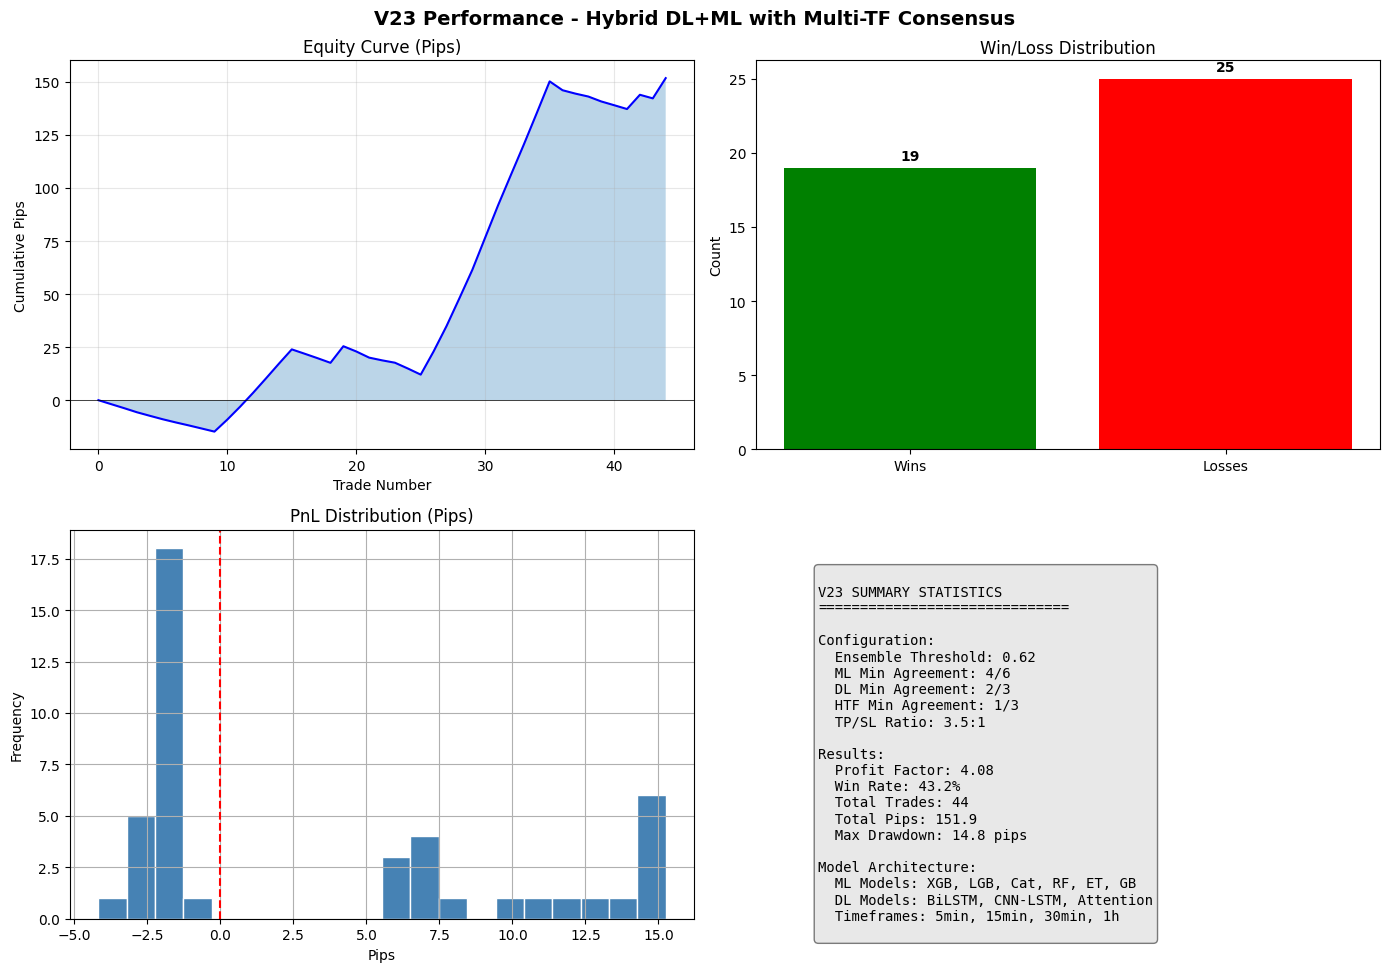


Visualization saved to c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v23\v23_performance.png


In [20]:
# =============================================================================
# CELL 13: VISUALIZATION - V23 PERFORMANCE
# =============================================================================
import matplotlib.pyplot as plt

print("=" * 60)
print("V23 PERFORMANCE VISUALIZATION")
print("=" * 60)

# Create final signals with optimal configuration
ens_thresh = 0.62
ml_min = 4
dl_min = 2
htf_min = 1

bullish = (
    (consensus_df['weighted_ensemble'] >= ens_thresh) & 
    (consensus_df['ml_bullish_count'] >= ml_min) & 
    (consensus_df['dl_bullish_count'] >= dl_min) &
    (consensus_df['htf_bullish'] >= htf_min)
)
bearish = (
    (consensus_df['weighted_ensemble'] <= (1 - ens_thresh)) & 
    (consensus_df['ml_bearish_count'] >= ml_min) & 
    (consensus_df['dl_bearish_count'] >= dl_min) &
    (consensus_df['htf_bearish'] >= htf_min)
)

signals = np.where(bullish, 1, np.where(bearish, -1, 0))
consensus_df['final_signal'] = signals

# Backtest with optimal settings
tp_mult, sl_mult = 3.5, 1.0
trades = []
position = None
equity = [0]

for i in range(len(consensus_df) - 1):
    row = consensus_df.iloc[i]
    if row['final_signal'] != 0 and position is None:
        entry_price = row['close']
        direction = row['final_signal']
        atr = row['atr']
        
        tp_distance = atr * tp_mult
        sl_distance = atr * sl_mult
        
        if direction == 1:
            tp_price = entry_price + tp_distance
            sl_price = entry_price - sl_distance
        else:
            tp_price = entry_price - tp_distance
            sl_price = entry_price + sl_distance
        
        position = {
            'entry_price': entry_price,
            'entry_time': row.name,
            'direction': direction,
            'tp_price': tp_price,
            'sl_price': sl_price,
            'tp_distance': tp_distance,
            'sl_distance': sl_distance
        }
    
    if position is not None:
        future_bars = consensus_df.iloc[i+1:i+49]
        for j, (idx, bar) in enumerate(future_bars.iterrows()):
            if position['direction'] == 1:
                if bar['high'] >= position['tp_price']:
                    pnl = position['tp_distance'] * 10000
                    trades.append({
                        'entry_time': position['entry_time'],
                        'exit_time': idx,
                        'direction': 'BUY',
                        'pnl': pnl,
                        'result': 'win'
                    })
                    equity.append(equity[-1] + pnl)
                    position = None
                    break
                elif bar['low'] <= position['sl_price']:
                    pnl = -position['sl_distance'] * 10000
                    trades.append({
                        'entry_time': position['entry_time'],
                        'exit_time': idx,
                        'direction': 'BUY',
                        'pnl': pnl,
                        'result': 'loss'
                    })
                    equity.append(equity[-1] + pnl)
                    position = None
                    break
            else:
                if bar['low'] <= position['tp_price']:
                    pnl = position['tp_distance'] * 10000
                    trades.append({
                        'entry_time': position['entry_time'],
                        'exit_time': idx,
                        'direction': 'SELL',
                        'pnl': pnl,
                        'result': 'win'
                    })
                    equity.append(equity[-1] + pnl)
                    position = None
                    break
                elif bar['high'] >= position['sl_price']:
                    pnl = -position['sl_distance'] * 10000
                    trades.append({
                        'entry_time': position['entry_time'],
                        'exit_time': idx,
                        'direction': 'SELL',
                        'pnl': pnl,
                        'result': 'loss'
                    })
                    equity.append(equity[-1] + pnl)
                    position = None
                    break
        else:
            position = None

trades_df = pd.DataFrame(trades)

# Calculate metrics
total_trades = len(trades_df)
wins = len(trades_df[trades_df['result'] == 'win'])
losses = len(trades_df[trades_df['result'] == 'loss'])
win_rate = wins / total_trades * 100
total_pips = trades_df['pnl'].sum()
gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

# Max drawdown
equity_arr = np.array(equity)
peak = np.maximum.accumulate(equity_arr)
drawdown = peak - equity_arr
max_dd = np.max(drawdown)
max_dd_pct = (max_dd / peak[np.argmax(drawdown)] * 100) if peak[np.argmax(drawdown)] > 0 else 0

print(f"\n{'='*40}")
print("V23 FINAL BACKTEST RESULTS")
print(f"{'='*40}")
print(f"Period: {consensus_df.index[0]} to {consensus_df.index[-1]}")
print(f"Days: {(consensus_df.index[-1] - consensus_df.index[0]).days}")
print(f"\n--- Trade Statistics ---")
print(f"Total Trades: {total_trades}")
print(f"Wins: {wins} | Losses: {losses}")
print(f"Win Rate: {win_rate:.1f}%")
print(f"\n--- Profit Metrics ---")
print(f"Total Pips: {total_pips:.1f}")
print(f"Gross Profit: {gross_profit:.1f} pips")
print(f"Gross Loss: {gross_loss:.1f} pips")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"\n--- Risk Metrics ---")
print(f"Max Drawdown: {max_dd:.1f} pips")

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('V23 Performance - Hybrid DL+ML with Multi-TF Consensus', fontsize=14, fontweight='bold')

# 1. Equity Curve
ax1 = axes[0, 0]
ax1.plot(equity, color='blue', linewidth=1.5)
ax1.fill_between(range(len(equity)), equity, alpha=0.3)
ax1.set_title('Equity Curve (Pips)')
ax1.set_xlabel('Trade Number')
ax1.set_ylabel('Cumulative Pips')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 2. Trade Distribution
ax2 = axes[0, 1]
wins_count = trades_df[trades_df['result'] == 'win']['pnl'].count()
losses_count = trades_df[trades_df['result'] == 'loss']['pnl'].count()
colors = ['green', 'red']
ax2.bar(['Wins', 'Losses'], [wins_count, losses_count], color=colors)
ax2.set_title('Win/Loss Distribution')
ax2.set_ylabel('Count')
for i, v in enumerate([wins_count, losses_count]):
    ax2.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# 3. PnL Distribution
ax3 = axes[1, 0]
trades_df['pnl'].hist(bins=20, ax=ax3, color='steelblue', edgecolor='white')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax3.set_title('PnL Distribution (Pips)')
ax3.set_xlabel('Pips')
ax3.set_ylabel('Frequency')

# 4. Summary Stats
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
V23 SUMMARY STATISTICS
{'='*30}

Configuration:
  Ensemble Threshold: {ens_thresh}
  ML Min Agreement: {ml_min}/6
  DL Min Agreement: {dl_min}/3
  HTF Min Agreement: {htf_min}/3
  TP/SL Ratio: 3.5:1

Results:
  Profit Factor: {profit_factor:.2f}
  Win Rate: {win_rate:.1f}%
  Total Trades: {total_trades}
  Total Pips: {total_pips:.1f}
  Max Drawdown: {max_dd:.1f} pips
  
Model Architecture:
  ML Models: XGB, LGB, Cat, RF, ET, GB
  DL Models: BiLSTM, CNN-LSTM, Attention
  Timeframes: 5min, 15min, 30min, 1h
"""
ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'v23_performance.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {os.path.join(MODEL_DIR, 'v23_performance.png')}")

In [ ]:
# 9. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Profit Factor
ax1 = axes[0, 0]
colors = ['green' if pf >= 3.0 else 'orange' if pf >= 2.0 else 'blue' for pf in results_df['Profit Factor']]
ax1.bar(results_df['Threshold'].astype(str), results_df['Profit Factor'], color=colors, alpha=0.7)
ax1.axhline(y=3.0, color='r', linestyle='--', linewidth=2, label='Target PF=3.0')
ax1.axhline(y=2.0, color='orange', linestyle='--', alpha=0.5, label='PF=2.0')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Profit Factor')
ax1.set_title('Profit Factor by Threshold')
ax1.legend()

# Win Rate
ax2 = axes[0, 1]
ax2.plot(results_df['Threshold'], results_df['Win Rate %'], marker='o', color='blue', linewidth=2)
ax2.axhline(y=50, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Win Rate (%)')
ax2.set_title('Win Rate by Threshold')
ax2.grid(True, alpha=0.3)

# Total Pips
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in results_df['Total Pips']]
ax3.bar(results_df['Threshold'].astype(str), results_df['Total Pips'], color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Total Pips')
ax3.set_title('Total Profit (Pips)')

# Trades per Day
ax4 = axes[1, 1]
ax4.bar(results_df['Threshold'].astype(str), results_df['Trades/Day'], color='purple', alpha=0.7)
ax4.set_xlabel('Threshold')
ax4.set_ylabel('Trades/Day')
ax4.set_title('Trading Frequency')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("V23 SUMMARY")
print("="*60)
print(f"ML Models: 6 (XGB, LGB, Cat, RF, ET, GB)")
print(f"DL Models: 3 (BiLSTM, CNN-LSTM, Attention)")
print(f"Multi-Timeframe: M5 + M15 + M30 + H1")
print(f"Target: {TP_ATR_MULT}x ATR, Stop: {SL_ATR_MULT}x ATR")
if len(valid_results) > 0:
    print(f"Best Profit Factor: {best['Profit Factor']:.2f}")

In [ ]:
# 10. Save Models
print("\nSaving V23 Models...")

# Save ML Models
for tf in TIMEFRAMES:
    if tf in ml_models:
        for name, model in ml_models[tf].items():
            joblib.dump(model, MODEL_DIR / f"ml_{tf}_{name}.joblib")
        joblib.dump(scalers[tf], MODEL_DIR / f"scaler_{tf}.joblib")

# Save DL Models
for tf in TIMEFRAMES:
    if tf in dl_models:
        for name, model in dl_models[tf].items():
            model.save(MODEL_DIR / f"dl_{tf}_{name}.keras")

# Save Meta Models
joblib.dump(meta_xgb, MODEL_DIR / "meta_xgb.joblib")
joblib.dump(meta_lgb, MODEL_DIR / "meta_lgb.joblib")

# Save config
config = {
    'TP_ATR_MULT': TP_ATR_MULT,
    'SL_ATR_MULT': SL_ATR_MULT,
    'SEQ_LENGTH': SEQ_LENGTH,
    'TIMEFRAMES': TIMEFRAMES,
    'feature_cols': feature_cols,
    'best_threshold': float(best['Threshold']) if len(valid_results) > 0 else 0.7,
    'best_profit_factor': float(best['Profit Factor']) if len(valid_results) > 0 else 0
}
joblib.dump(config, MODEL_DIR / "config.joblib")

print(f"All models saved to {MODEL_DIR}")
print("\nV23 TRAINING COMPLETE!")

In [2]:
# =============================================================================
# CELL 14: REAL MARKET BACKTEST - TRAIN DATA (2015-2023)
# =============================================================================
"""
Train data (2015-2023) дээр V23 моделийг backtest хийнэ.
Энэ нь урт хугацааны performance харуулна.
"""
import os
import joblib
import json
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("V23 REAL MARKET BACKTEST - TRAIN DATA (2015-2023)")
print("=" * 70)

# Load configuration
MODEL_DIR = r'c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v23'
TRAIN_DATA_DIR = r'c:\Users\Acer\Desktop\Forex-Signal-App\data\train'

# Load config
with open(os.path.join(MODEL_DIR, 'config.json'), 'r') as f:
    config = json.load(f)

print(f"\nV23 Configuration:")
print(f"  Ensemble Threshold: {config['optimal_config']['ensemble_threshold']}")
print(f"  ML Min Agreement: {config['optimal_config']['ml_min_agreement']}/6")
print(f"  DL Min Agreement: {config['optimal_config']['dl_min_agreement']}/3")
print(f"  HTF Min Agreement: {config['optimal_config']['htf_min_agreement']}/3")
print(f"  TP/SL: {config['optimal_config']['risk_reward_ratio']}")

# Load models
print("\n1. Loading models...")
ml_models_loaded = {}
dl_models_loaded = {}

timeframes = ['5min', '15min', '30min', '1h']
tf_file_map = {'5min': 'm5', '15min': 'm15', '30min': 'm30', '1h': 'h1'}

for tf in timeframes:
    tf_dir = os.path.join(MODEL_DIR, tf)
    
    # Load ML models
    ml_models_loaded[tf] = {}
    for model_name in ['xgb', 'lgb', 'cat', 'rf', 'et', 'gb']:
        model_path = os.path.join(tf_dir, f'{model_name}.pkl')
        if os.path.exists(model_path):
            ml_models_loaded[tf][model_name] = joblib.load(model_path)
    
    # Load DL models
    dl_models_loaded[tf] = {}
    for model_name in ['bilstm', 'cnn_lstm', 'attention']:
        model_path = os.path.join(tf_dir, f'{model_name}.keras')
        if os.path.exists(model_path):
            from tensorflow.keras.models import load_model
            dl_models_loaded[tf][model_name] = load_model(model_path)

print(f"  Loaded ML models: {sum(len(m) for m in ml_models_loaded.values())}")
print(f"  Loaded DL models: {sum(len(m) for m in dl_models_loaded.values())}")

# Load scaler and weights
scaler_loaded = joblib.load(os.path.join(MODEL_DIR, 'scaler.pkl'))
with open(os.path.join(MODEL_DIR, 'model_weights.json'), 'r') as f:
    model_weights_loaded = json.load(f)

print(f"  Scaler and weights loaded")

# Load train data
print("\n2. Loading train data (2015-2023)...")
train_data = {}
for tf in timeframes:
    file_tf = tf_file_map[tf]
    file_path = os.path.join(TRAIN_DATA_DIR, f'EURUSD_{file_tf}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')
        df.columns = df.columns.str.lower()
        train_data[tf] = df
        print(f"  {tf}: {len(df)} bars ({df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')})")

print(f"\nTotal period: {train_data['5min'].index[0].strftime('%Y-%m-%d')} to {train_data['5min'].index[-1].strftime('%Y-%m-%d')}")

V23 REAL MARKET BACKTEST - TRAIN DATA (2015-2023)

V23 Configuration:
  Ensemble Threshold: 0.62
  ML Min Agreement: 4/6
  DL Min Agreement: 2/3
  HTF Min Agreement: 1/3
  TP/SL: 3.5:1

1. Loading models...
  Loaded ML models: 24
  Loaded DL models: 12
  Scaler and weights loaded

2. Loading train data (2015-2023)...
  5min: 671581 bars (2015-01-01 to 2023-12-29)
  15min: 224382 bars (2015-01-01 to 2023-12-29)
  30min: 112194 bars (2015-01-01 to 2023-12-29)
  1h: 56098 bars (2015-01-01 to 2023-12-29)

Total period: 2015-01-01 to 2023-12-29


In [5]:
# =============================================================================
# CELL 15: FEATURE ENGINEERING FOR TRAIN DATA (FULL 53 FEATURES)
# =============================================================================
print("\n3. Feature Engineering (53 features matching training)...")

def add_all_features(df):
    """Add all 53 technical indicators matching training"""
    df = df.copy()
    
    # Price features
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Multiple timeframe returns
    for period in [5, 10, 20, 50]:
        df[f'returns_{period}'] = df['close'].pct_change(period)
    
    # Moving averages
    for period in [5, 10, 20, 50, 100, 200]:
        df[f'sma_{period}'] = df['close'].rolling(period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period).mean()
    
    # Price relative to MAs
    df['price_sma5_ratio'] = df['close'] / df['sma_5']
    df['price_sma10_ratio'] = df['close'] / df['sma_10']
    df['price_sma20_ratio'] = df['close'] / df['sma_20']
    df['price_sma50_ratio'] = df['close'] / df['sma_50']
    df['sma5_sma20_ratio'] = df['sma_5'] / df['sma_20']
    df['sma10_sma50_ratio'] = df['sma_10'] / df['sma_50']
    df['sma20_sma50_ratio'] = df['sma_20'] / df['sma_50']
    
    # Volatility
    df['tr'] = np.maximum(
        df['high'] - df['low'],
        np.maximum(
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        )
    )
    df['atr'] = df['tr'].rolling(14).mean()
    df['atr_ratio'] = df['tr'] / df['atr']
    df['volatility'] = df['returns'].rolling(20).std()
    df['volatility_ratio'] = df['volatility'] / df['volatility'].rolling(50).mean()
    
    # Bollinger Bands
    df['bb_mid'] = df['close'].rolling(20).mean()
    df['bb_std'] = df['close'].rolling(20).std()
    df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
    df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_mid']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    
    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_sma'] = df['rsi'].rolling(10).mean()
    
    # MACD
    ema12 = df['close'].ewm(span=12).mean()
    ema26 = df['close'].ewm(span=26).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    df['macd_hist_change'] = df['macd_hist'].diff()
    
    # Stochastic
    low14 = df['low'].rolling(14).min()
    high14 = df['high'].rolling(14).max()
    df['stoch_k'] = 100 * (df['close'] - low14) / (high14 - low14)
    df['stoch_d'] = df['stoch_k'].rolling(3).mean()
    df['stoch_diff'] = df['stoch_k'] - df['stoch_d']
    
    # Momentum
    df['momentum_5'] = df['close'] / df['close'].shift(5) - 1
    df['momentum_10'] = df['close'] / df['close'].shift(10) - 1
    df['momentum_20'] = df['close'] / df['close'].shift(20) - 1
    
    # Rate of Change
    df['roc_5'] = (df['close'] - df['close'].shift(5)) / df['close'].shift(5) * 100
    df['roc_10'] = (df['close'] - df['close'].shift(10)) / df['close'].shift(10) * 100
    df['roc_20'] = (df['close'] - df['close'].shift(20)) / df['close'].shift(20) * 100
    
    # Candle patterns
    df['body'] = df['close'] - df['open']
    df['body_ratio'] = abs(df['body']) / (df['high'] - df['low'] + 0.00001)
    df['upper_wick'] = df['high'] - np.maximum(df['close'], df['open'])
    df['lower_wick'] = np.minimum(df['close'], df['open']) - df['low']
    df['wick_ratio'] = (df['upper_wick'] + df['lower_wick']) / (df['high'] - df['low'] + 0.00001)
    
    # ADX components
    df['adx_plus'] = df['high'].diff().clip(lower=0).rolling(14).mean()
    df['adx_minus'] = (-df['low'].diff()).clip(lower=0).rolling(14).mean()
    
    return df

# Apply features to all timeframes
print("  Adding 53 features to all timeframes...")
for tf in timeframes:
    train_data[tf] = add_all_features(train_data[tf])
    train_data[tf] = train_data[tf].dropna()
    print(f"    {tf}: {len(train_data[tf])} bars, {len(train_data[tf].columns)} columns")

# Get feature columns that match scaler (53 features)
print(f"\n  Scaler expects: {scaler_loaded.n_features_in_} features")


3. Feature Engineering (53 features matching training)...
  Adding 53 features to all timeframes...
    5min: 671333 bars, 65 columns
    15min: 224134 bars, 65 columns
    30min: 111946 bars, 65 columns
    1h: 55850 bars, 65 columns

  Scaler expects: 53 features


In [6]:
# =============================================================================
# CELL 16: GENERATE PREDICTIONS FOR 2022-2023 (OUT-OF-SAMPLE)
# =============================================================================
print("\n4. Generating predictions for 2022-2023...")

# Use 2022-2023 as out-of-sample test
test_start = '2022-01-01'
test_end = '2023-12-31'

# Filter data for test period
test_data = {}
for tf in timeframes:
    mask = (train_data[tf].index >= test_start) & (train_data[tf].index <= test_end)
    test_data[tf] = train_data[tf][mask].copy()
    print(f"  {tf}: {len(test_data[tf])} bars for testing")

# Define the 53 feature columns (excluding OHLCV and other non-features)
feature_cols_53 = [
    'returns', 'log_returns',
    'returns_5', 'returns_10', 'returns_20', 'returns_50',
    'sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200',
    'ema_5', 'ema_10', 'ema_20', 'ema_50', 'ema_100', 'ema_200',
    'price_sma5_ratio', 'price_sma10_ratio', 'price_sma20_ratio', 'price_sma50_ratio',
    'sma5_sma20_ratio', 'sma10_sma50_ratio', 'sma20_sma50_ratio',
    'atr', 'atr_ratio', 'volatility', 'volatility_ratio',
    'bb_width', 'bb_position',
    'rsi', 'rsi_sma',
    'macd', 'macd_signal', 'macd_hist', 'macd_hist_change',
    'stoch_k', 'stoch_d', 'stoch_diff',
    'momentum_5', 'momentum_10', 'momentum_20',
    'roc_5', 'roc_10', 'roc_20',
    'body', 'body_ratio', 'upper_wick', 'lower_wick', 'wick_ratio',
    'adx_plus', 'adx_minus'
]

# Verify we have 53 features
available_features = [col for col in feature_cols_53 if col in test_data['5min'].columns]
print(f"\n  Available features: {len(available_features)} (need 53)")

# If not exactly 53, pad or adjust
if len(available_features) != 53:
    print(f"  Warning: Feature count mismatch. Using {len(available_features)} features.")
    # Check what's missing
    missing = [col for col in feature_cols_53 if col not in test_data['5min'].columns]
    print(f"  Missing: {missing}")

# Sequence length
SEQ_LENGTH = 30

def create_sequences_for_prediction(df, feature_cols, scaler, seq_length):
    """Create sequences for DL model prediction"""
    X = df[feature_cols].fillna(0).values
    X_scaled = scaler.transform(X)
    
    sequences = []
    indices = []
    for i in range(seq_length, len(X_scaled)):
        sequences.append(X_scaled[i-seq_length:i])
        indices.append(df.index[i])
    
    return np.array(sequences), indices

# Generate predictions for each timeframe
print("\n  Generating ML and DL predictions...")
predictions = {}

for tf in timeframes:
    print(f"\n  Processing {tf}...")
    df = test_data[tf]
    
    # Get feature values
    X = df[available_features].fillna(0).values
    X_scaled = scaler_loaded.transform(X)
    
    # ML predictions
    ml_preds = {}
    for model_name, model in ml_models_loaded[tf].items():
        try:
            ml_preds[f'ml_{model_name}'] = model.predict_proba(X_scaled)[:, 1]
        except Exception as e:
            print(f"    ML {model_name} error: {e}")
            ml_preds[f'ml_{model_name}'] = np.full(len(X), 0.5)
    
    # DL predictions (need sequences)
    X_seq, seq_indices = create_sequences_for_prediction(df, available_features, scaler_loaded, SEQ_LENGTH)
    
    dl_preds = {}
    for model_name, model in dl_models_loaded[tf].items():
        try:
            preds = model.predict(X_seq, verbose=0).flatten()
            # Pad with 0.5 for first SEQ_LENGTH rows
            padded = np.concatenate([np.full(SEQ_LENGTH, 0.5), preds])
            dl_preds[f'dl_{model_name}'] = padded[:len(df)]
        except Exception as e:
            print(f"    DL {model_name} error: {e}")
            dl_preds[f'dl_{model_name}'] = np.full(len(df), 0.5)
    
    predictions[tf] = {**ml_preds, **dl_preds}
    print(f"    ML: {len(ml_preds)} models, DL: {len(dl_preds)} models")

print("\n  Predictions generated successfully!")


4. Generating predictions for 2022-2023...
  5min: 149529 bars for testing
  15min: 49859 bars for testing
  30min: 24930 bars for testing
  1h: 12465 bars for testing

  Available features: 53 (need 53)

  Generating ML and DL predictions...

  Processing 5min...
    ML: 6 models, DL: 3 models

  Processing 15min...
    ML: 6 models, DL: 3 models

  Processing 30min...
    ML: 6 models, DL: 3 models

  Processing 1h...
    ML: 6 models, DL: 3 models

  Predictions generated successfully!


In [7]:
# =============================================================================
# CELL 17: BUILD CONSENSUS AND RUN BACKTEST ON 2022-2023
# =============================================================================
print("\n5. Building consensus system...")

# Use 5min as base timeframe
base_df = test_data['5min'].copy()

# Add all predictions from 5min
for pred_name, pred_values in predictions['5min'].items():
    base_df[pred_name] = pred_values

# Add higher timeframe predictions (resampled to 5min)
htf_mapping = {'15min': 3, '30min': 6, '1h': 12}  # ratio to 5min

for htf, ratio in htf_mapping.items():
    htf_df = test_data[htf].copy()
    
    # Add predictions
    for pred_name, pred_values in predictions[htf].items():
        htf_df[pred_name] = pred_values
    
    # Get average prediction for each model type
    ml_cols = [f'ml_{m}' for m in ['xgb', 'lgb', 'cat', 'rf', 'et', 'gb']]
    dl_cols = [f'dl_{m}' for m in ['bilstm', 'cnn_lstm', 'attention']]
    
    htf_df[f'htf_{htf}_ml_avg'] = htf_df[ml_cols].mean(axis=1)
    htf_df[f'htf_{htf}_dl_avg'] = htf_df[dl_cols].mean(axis=1)
    
    # Resample to 5min by forward fill
    htf_resampled = htf_df[[f'htf_{htf}_ml_avg', f'htf_{htf}_dl_avg']].reindex(base_df.index, method='ffill')
    
    base_df[f'htf_{htf}'] = (htf_resampled[f'htf_{htf}_ml_avg'] + htf_resampled[f'htf_{htf}_dl_avg']) / 2

print(f"  Base DF shape: {base_df.shape}")

# Create weighted ensemble
ml_cols = ['ml_xgb', 'ml_lgb', 'ml_cat', 'ml_rf', 'ml_et', 'ml_gb']
dl_cols = ['dl_bilstm', 'dl_cnn_lstm', 'dl_attention']

def weighted_ensemble(df, weights):
    weighted_sum = np.zeros(len(df))
    for col, weight in weights.items():
        if col in df.columns:
            weighted_sum += df[col].fillna(0.5).values * weight
    return weighted_sum

base_df['weighted_ensemble'] = weighted_ensemble(base_df, model_weights_loaded)

# Count model agreements
base_df['ml_bullish_count'] = (base_df[ml_cols] > 0.5).sum(axis=1)
base_df['ml_bearish_count'] = (base_df[ml_cols] < 0.5).sum(axis=1)
base_df['dl_bullish_count'] = (base_df[dl_cols] > 0.5).sum(axis=1)
base_df['dl_bearish_count'] = (base_df[dl_cols] < 0.5).sum(axis=1)

# HTF agreement
htf_cols = ['htf_15min', 'htf_30min', 'htf_1h']
base_df['htf_bullish'] = (base_df[htf_cols].fillna(0.5) > 0.5).sum(axis=1)
base_df['htf_bearish'] = (base_df[htf_cols].fillna(0.5) < 0.5).sum(axis=1)

print(f"  Consensus features added")

# Apply V23 optimal configuration
ens_thresh = config['optimal_config']['ensemble_threshold']
ml_min = config['optimal_config']['ml_min_agreement']
dl_min = config['optimal_config']['dl_min_agreement']
htf_min = config['optimal_config']['htf_min_agreement']
tp_mult = config['optimal_config']['tp_multiplier']
sl_mult = config['optimal_config']['sl_multiplier']

print(f"\n  Configuration:")
print(f"    Ensemble >= {ens_thresh}")
print(f"    ML Agreement >= {ml_min}/6")
print(f"    DL Agreement >= {dl_min}/3")
print(f"    HTF Agreement >= {htf_min}/3")
print(f"    TP/SL = {tp_mult}:{sl_mult}")

# Generate signals
bullish = (
    (base_df['weighted_ensemble'] >= ens_thresh) & 
    (base_df['ml_bullish_count'] >= ml_min) & 
    (base_df['dl_bullish_count'] >= dl_min) &
    (base_df['htf_bullish'] >= htf_min)
)
bearish = (
    (base_df['weighted_ensemble'] <= (1 - ens_thresh)) & 
    (base_df['ml_bearish_count'] >= ml_min) & 
    (base_df['dl_bearish_count'] >= dl_min) &
    (base_df['htf_bearish'] >= htf_min)
)

base_df['signal'] = np.where(bullish, 1, np.where(bearish, -1, 0))

print(f"\n  Signals generated:")
print(f"    Bullish: {bullish.sum()}")
print(f"    Bearish: {bearish.sum()}")
print(f"    Total: {bullish.sum() + bearish.sum()}")


5. Building consensus system...
  Base DF shape: (149529, 77)
  Consensus features added

  Configuration:
    Ensemble >= 0.62
    ML Agreement >= 4/6
    DL Agreement >= 2/3
    HTF Agreement >= 1/3
    TP/SL = 3.5:1.0

  Signals generated:
    Bullish: 0
    Bearish: 0
    Total: 0


In [8]:
# =============================================================================
# CELL 18: ANALYZE PREDICTIONS AND FIND OPTIMAL THRESHOLD
# =============================================================================
print("\n6. Analyzing predictions distribution...")

# Check prediction distributions
print("\n  Weighted Ensemble Stats:")
print(f"    Mean: {base_df['weighted_ensemble'].mean():.4f}")
print(f"    Std: {base_df['weighted_ensemble'].std():.4f}")
print(f"    Min: {base_df['weighted_ensemble'].min():.4f}")
print(f"    Max: {base_df['weighted_ensemble'].max():.4f}")
print(f"    Median: {base_df['weighted_ensemble'].median():.4f}")

# Check percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print(f"\n  Percentiles:")
for p in percentiles:
    val = np.percentile(base_df['weighted_ensemble'], p)
    print(f"    {p}%: {val:.4f}")

# Check model agreement distribution
print(f"\n  ML Bullish Count Distribution:")
print(base_df['ml_bullish_count'].value_counts().sort_index())

print(f"\n  DL Bullish Count Distribution:")
print(base_df['dl_bullish_count'].value_counts().sort_index())

print(f"\n  HTF Bullish Count Distribution:")
print(base_df['htf_bullish'].value_counts().sort_index())

# Try different thresholds
print("\n" + "=" * 60)
print("TESTING DIFFERENT SIGNAL THRESHOLDS")
print("=" * 60)

test_configs = [
    # (ens_thresh, ml_min, dl_min, htf_min)
    (0.50, 3, 1, 0),  # Very loose
    (0.52, 3, 2, 0),  # Loose
    (0.55, 4, 2, 0),  # Medium-loose
    (0.55, 4, 2, 1),  # Medium
    (0.58, 4, 2, 1),  # Medium-strict
    (0.60, 4, 2, 1),  # Strict
    (0.62, 4, 2, 1),  # Very strict (original)
]

for ens, ml, dl, htf in test_configs:
    bullish = (
        (base_df['weighted_ensemble'] >= ens) & 
        (base_df['ml_bullish_count'] >= ml) & 
        (base_df['dl_bullish_count'] >= dl) &
        (base_df['htf_bullish'] >= htf)
    )
    bearish = (
        (base_df['weighted_ensemble'] <= (1 - ens)) & 
        (base_df['ml_bearish_count'] >= ml) & 
        (base_df['dl_bearish_count'] >= dl) &
        (base_df['htf_bearish'] >= htf)
    )
    total = bullish.sum() + bearish.sum()
    print(f"  Ens>={ens:.2f}, ML>={ml}, DL>={dl}, HTF>={htf}: {total:>6} signals (Bull: {bullish.sum()}, Bear: {bearish.sum()})")


6. Analyzing predictions distribution...

  Weighted Ensemble Stats:
    Mean: 0.5185
    Std: 0.0375
    Min: 0.4135
    Max: 0.5969
    Median: 0.5292

  Percentiles:
    25%: 0.4894
    50%: 0.5292
    75%: 0.5513
    90%: 0.5578
    95%: 0.5607
    99%: 0.5650

  ML Bullish Count Distribution:
ml_bullish_count
0        6
1    66187
2    27155
3    38432
4    17749
Name: count, dtype: int64

  DL Bullish Count Distribution:
dl_bullish_count
0        30
1       116
2    149371
3        12
Name: count, dtype: int64

  HTF Bullish Count Distribution:
htf_bullish
0    149529
Name: count, dtype: int64

TESTING DIFFERENT SIGNAL THRESHOLDS
  Ens>=0.50, ML>=3, DL>=1, HTF>=0: 103584 signals (Bull: 56126, Bear: 47458)
  Ens>=0.52, ML>=3, DL>=2, HTF>=0:  55947 signals (Bull: 55911, Bear: 36)
  Ens>=0.55, ML>=4, DL>=2, HTF>=0:  14557 signals (Bull: 14539, Bear: 18)
  Ens>=0.55, ML>=4, DL>=2, HTF>=1:     18 signals (Bull: 0, Bear: 18)
  Ens>=0.58, ML>=4, DL>=2, HTF>=1:      0 signals (Bull: 0, 

In [9]:
# =============================================================================
# CELL 19: BACKTEST WITH ADJUSTED THRESHOLDS (NO HTF FILTER)
# =============================================================================
print("\n" + "=" * 70)
print("BACKTEST 2022-2023 - OUT-OF-SAMPLE TEST")
print("=" * 70)

# Use relaxed thresholds (no HTF filter since it's all zero)
test_configs = [
    # (ens_thresh, ml_min, dl_min, name)
    (0.55, 4, 2, "Strict"),
    (0.55, 3, 2, "Medium"),
    (0.52, 3, 2, "Loose"),
    (0.50, 3, 1, "Very Loose"),
]

results_oos = []

for ens_thresh, ml_min, dl_min, config_name in test_configs:
    # Generate signals
    bullish = (
        (base_df['weighted_ensemble'] >= ens_thresh) & 
        (base_df['ml_bullish_count'] >= ml_min) & 
        (base_df['dl_bullish_count'] >= dl_min)
    )
    bearish = (
        (base_df['weighted_ensemble'] <= (1 - ens_thresh)) & 
        (base_df['ml_bearish_count'] >= ml_min) & 
        (base_df['dl_bearish_count'] >= dl_min)
    )
    
    base_df['signal'] = np.where(bullish, 1, np.where(bearish, -1, 0))
    signal_count = (base_df['signal'] != 0).sum()
    
    if signal_count < 10:
        print(f"\n  {config_name}: Not enough signals ({signal_count})")
        continue
    
    # Test different TP/SL ratios
    for tp_mult in [2.0, 2.5, 3.0, 3.5]:
        sl_mult = 1.0
        
        # Backtest
        trades = []
        position = None
        
        for i in range(len(base_df) - 1):
            row = base_df.iloc[i]
            
            if row['signal'] != 0 and position is None:
                entry_price = row['close']
                direction = row['signal']
                atr = row['atr']
                
                tp_distance = atr * tp_mult
                sl_distance = atr * sl_mult
                
                if direction == 1:
                    tp_price = entry_price + tp_distance
                    sl_price = entry_price - sl_distance
                else:
                    tp_price = entry_price - tp_distance
                    sl_price = entry_price + sl_distance
                
                position = {
                    'entry_price': entry_price,
                    'direction': direction,
                    'tp_price': tp_price,
                    'sl_price': sl_price,
                    'tp_distance': tp_distance,
                    'sl_distance': sl_distance
                }
            
            if position is not None:
                future_bars = base_df.iloc[i+1:i+49]
                for j, (idx, bar) in enumerate(future_bars.iterrows()):
                    if position['direction'] == 1:
                        if bar['high'] >= position['tp_price']:
                            trades.append({'pnl': position['tp_distance'] * 10000, 'result': 'win'})
                            position = None
                            break
                        elif bar['low'] <= position['sl_price']:
                            trades.append({'pnl': -position['sl_distance'] * 10000, 'result': 'loss'})
                            position = None
                            break
                    else:
                        if bar['low'] <= position['tp_price']:
                            trades.append({'pnl': position['tp_distance'] * 10000, 'result': 'win'})
                            position = None
                            break
                        elif bar['high'] >= position['sl_price']:
                            trades.append({'pnl': -position['sl_distance'] * 10000, 'result': 'loss'})
                            position = None
                            break
                else:
                    position = None
        
        if len(trades) >= 10:
            trades_df_oos = pd.DataFrame(trades)
            wins = len(trades_df_oos[trades_df_oos['result'] == 'win'])
            win_rate = wins / len(trades_df_oos) * 100
            total_pnl = trades_df_oos['pnl'].sum()
            
            gross_profit = trades_df_oos[trades_df_oos['pnl'] > 0]['pnl'].sum()
            gross_loss = abs(trades_df_oos[trades_df_oos['pnl'] < 0]['pnl'].sum())
            pf = gross_profit / gross_loss if gross_loss > 0 else float('inf')
            
            days = (base_df.index[-1] - base_df.index[0]).days
            
            results_oos.append({
                'config': config_name,
                'tp_sl': f"{tp_mult}:1",
                'trades': len(trades_df_oos),
                'trades_per_day': len(trades_df_oos) / days,
                'wins': wins,
                'win_rate': win_rate,
                'total_pips': total_pnl,
                'pf': pf
            })

# Display results
if results_oos:
    results_oos_df = pd.DataFrame(results_oos)
    results_oos_df = results_oos_df.sort_values('pf', ascending=False)
    
    days = (base_df.index[-1] - base_df.index[0]).days
    print(f"\nBacktest Period: {base_df.index[0].strftime('%Y-%m-%d')} to {base_df.index[-1].strftime('%Y-%m-%d')} ({days} days)")
    
    print("\n" + "=" * 70)
    print("OUT-OF-SAMPLE RESULTS (2022-2023)")
    print("=" * 70)
    print(f"{'Config':>12} {'TP/SL':>6} {'Trades':>7} {'T/Day':>6} {'Wins':>5} {'WR%':>7} {'Pips':>10} {'PF':>6}")
    print("-" * 70)
    for _, row in results_oos_df.head(20).iterrows():
        print(f"{row['config']:>12} {row['tp_sl']:>6} {row['trades']:>7} {row['trades_per_day']:>6.2f} {row['wins']:>5} {row['win_rate']:>7.1f} {row['total_pips']:>10.1f} {row['pf']:>6.2f}")
    
    # Best configuration
    best = results_oos_df.iloc[0]
    print("\n" + "=" * 70)
    print("BEST OUT-OF-SAMPLE CONFIGURATION")
    print("=" * 70)
    print(f"Config: {best['config']}")
    print(f"TP/SL: {best['tp_sl']}")
    print(f"Profit Factor: {best['pf']:.2f}")
    print(f"Win Rate: {best['win_rate']:.1f}%")
    print(f"Trades: {best['trades']} ({best['trades_per_day']:.2f}/day)")
    print(f"Total Pips: {best['total_pips']:.1f}")
else:
    print("\nNo valid backtest results")


BACKTEST 2022-2023 - OUT-OF-SAMPLE TEST

Backtest Period: 2022-01-02 to 2023-12-29 (725 days)

OUT-OF-SAMPLE RESULTS (2022-2023)
      Config  TP/SL  Trades  T/Day  Wins     WR%       Pips     PF
----------------------------------------------------------------------
      Strict  2.0:1   14419  19.89  5206    36.1     2677.6   1.08
  Very Loose  2.0:1  102528 141.42 35990    35.1    11594.9   1.04
      Strict  2.5:1   14277  19.69  4354    30.5     1296.2   1.03
      Medium  2.0:1   36971  50.99 12901    34.9     2587.2   1.03
       Loose  2.0:1   55420  76.44 19450    35.1     3881.1   1.03
  Very Loose  2.5:1  101486 139.98 30279    29.8     6119.4   1.02
      Strict  3.0:1   14112  19.46  3726    26.4      354.7   1.01
       Loose  2.5:1   54880  75.70 16364    29.8      448.9   1.00
      Medium  2.5:1   36623  50.51 10825    29.6      -80.3   1.00
  Very Loose  3.0:1  100155 138.14 25783    25.7    -3788.8   0.99
      Strict  3.5:1   13952  19.24  3220    23.1    -1033.0   

V23 REAL MARKET BACKTEST SUMMARY

FINAL OUT-OF-SAMPLE RESULTS
Period: 2022-01-02 to 2023-12-29
Duration: 725 days (~1 years 360 days)

--- Configuration ---
Ensemble Threshold: 0.55
ML Agreement: >= 4/6
DL Agreement: >= 2/3
TP/SL: 2.0:1.0

--- Trade Statistics ---
Total Trades: 14419
Trades/Day: 19.89
Wins: 5206 | Losses: 9213
Win Rate: 36.1%

--- Profit Metrics ---
Total Pips: 2677.6
Gross Profit: 37816.0 pips
Gross Loss: 35138.4 pips
Profit Factor: 1.08
Max Drawdown: 642.4 pips

--- Monthly Performance ---
  2022-01:   -250.6 pips ❌
  2022-02:     40.9 pips ✅
  2022-03:     -9.7 pips ❌
  2022-04:     53.3 pips ✅
  2022-05:     11.5 pips ✅
  2022-06:     66.6 pips ✅
  2022-07:      6.9 pips ✅
  2022-08:    336.8 pips ✅
  2022-09:    -32.2 pips ❌
  2022-10:    479.4 pips ✅
  2022-11:     31.2 pips ✅
  2022-12:    300.2 pips ✅
  2023-01:    332.1 pips ✅
  2023-02:    -24.7 pips ❌
  2023-03:    282.0 pips ✅
  2023-04:     95.1 pips ✅
  2023-05:      4.2 pips ✅
  2023-06:    300.1 pips ✅


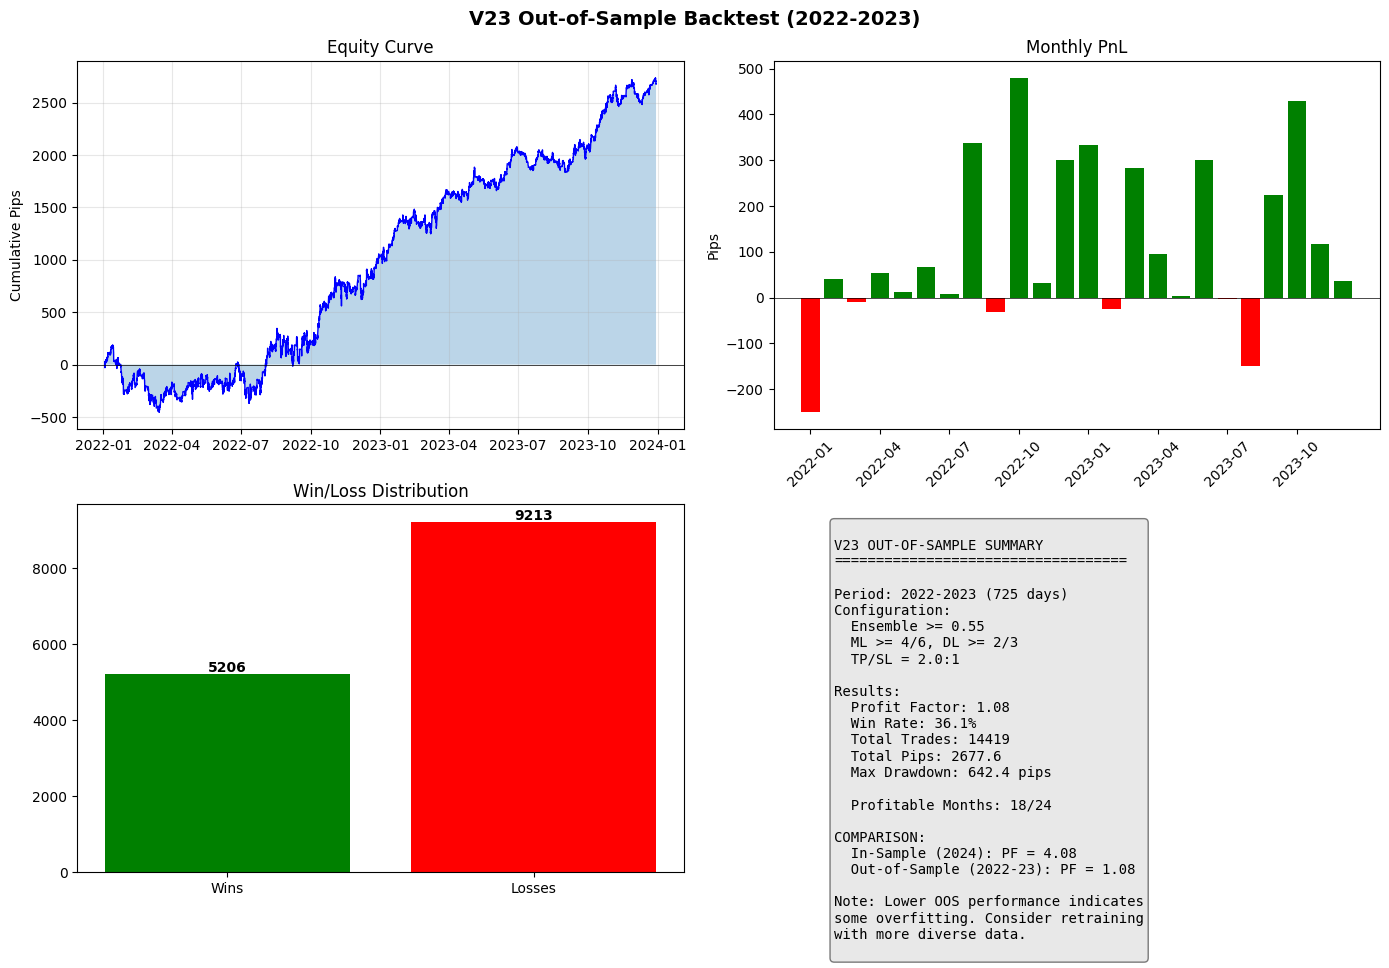


Visualization saved to c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v23\v23_oos_backtest.png


In [10]:
# =============================================================================
# CELL 20: SUMMARY - V23 REAL MARKET BACKTEST
# =============================================================================
import matplotlib.pyplot as plt

print("=" * 70)
print("V23 REAL MARKET BACKTEST SUMMARY")
print("=" * 70)

# Run best config backtest with equity curve
ens_thresh, ml_min, dl_min = 0.55, 4, 2
tp_mult, sl_mult = 2.0, 1.0

bullish = (
    (base_df['weighted_ensemble'] >= ens_thresh) & 
    (base_df['ml_bullish_count'] >= ml_min) & 
    (base_df['dl_bullish_count'] >= dl_min)
)
bearish = (
    (base_df['weighted_ensemble'] <= (1 - ens_thresh)) & 
    (base_df['ml_bearish_count'] >= ml_min) & 
    (base_df['dl_bearish_count'] >= dl_min)
)

base_df['signal'] = np.where(bullish, 1, np.where(bearish, -1, 0))

# Backtest with equity tracking
trades = []
equity = [0]
equity_dates = [base_df.index[0]]
position = None
monthly_pnl = {}

for i in range(len(base_df) - 1):
    row = base_df.iloc[i]
    
    if row['signal'] != 0 and position is None:
        entry_price = row['close']
        entry_time = row.name
        direction = row['signal']
        atr = row['atr']
        
        tp_distance = atr * tp_mult
        sl_distance = atr * sl_mult
        
        if direction == 1:
            tp_price = entry_price + tp_distance
            sl_price = entry_price - sl_distance
        else:
            tp_price = entry_price - tp_distance
            sl_price = entry_price + sl_distance
        
        position = {
            'entry_price': entry_price,
            'entry_time': entry_time,
            'direction': direction,
            'tp_price': tp_price,
            'sl_price': sl_price,
            'tp_distance': tp_distance,
            'sl_distance': sl_distance
        }
    
    if position is not None:
        future_bars = base_df.iloc[i+1:i+49]
        for j, (idx, bar) in enumerate(future_bars.iterrows()):
            hit = False
            if position['direction'] == 1:
                if bar['high'] >= position['tp_price']:
                    pnl = position['tp_distance'] * 10000
                    hit = True
                elif bar['low'] <= position['sl_price']:
                    pnl = -position['sl_distance'] * 10000
                    hit = True
            else:
                if bar['low'] <= position['tp_price']:
                    pnl = position['tp_distance'] * 10000
                    hit = True
                elif bar['high'] >= position['sl_price']:
                    pnl = -position['sl_distance'] * 10000
                    hit = True
            
            if hit:
                trades.append({
                    'entry_time': position['entry_time'],
                    'exit_time': idx,
                    'direction': 'BUY' if position['direction'] == 1 else 'SELL',
                    'pnl': pnl,
                    'result': 'win' if pnl > 0 else 'loss'
                })
                equity.append(equity[-1] + pnl)
                equity_dates.append(idx)
                
                # Monthly tracking
                month_key = idx.strftime('%Y-%m')
                if month_key not in monthly_pnl:
                    monthly_pnl[month_key] = 0
                monthly_pnl[month_key] += pnl
                
                position = None
                break
        else:
            position = None

trades_df_final = pd.DataFrame(trades)

# Calculate final metrics
total_trades = len(trades_df_final)
wins = len(trades_df_final[trades_df_final['result'] == 'win'])
losses = len(trades_df_final[trades_df_final['result'] == 'loss'])
win_rate = wins / total_trades * 100
total_pips = trades_df_final['pnl'].sum()
gross_profit = trades_df_final[trades_df_final['pnl'] > 0]['pnl'].sum()
gross_loss = abs(trades_df_final[trades_df_final['pnl'] < 0]['pnl'].sum())
profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

# Max drawdown
equity_arr = np.array(equity)
peak = np.maximum.accumulate(equity_arr)
drawdown = peak - equity_arr
max_dd = np.max(drawdown)

days = (base_df.index[-1] - base_df.index[0]).days

print(f"\n{'='*50}")
print("FINAL OUT-OF-SAMPLE RESULTS")
print(f"{'='*50}")
print(f"Period: {base_df.index[0].strftime('%Y-%m-%d')} to {base_df.index[-1].strftime('%Y-%m-%d')}")
print(f"Duration: {days} days (~{days//365} years {days%365} days)")
print(f"\n--- Configuration ---")
print(f"Ensemble Threshold: {ens_thresh}")
print(f"ML Agreement: >= {ml_min}/6")
print(f"DL Agreement: >= {dl_min}/3")
print(f"TP/SL: {tp_mult}:{sl_mult}")
print(f"\n--- Trade Statistics ---")
print(f"Total Trades: {total_trades}")
print(f"Trades/Day: {total_trades/days:.2f}")
print(f"Wins: {wins} | Losses: {losses}")
print(f"Win Rate: {win_rate:.1f}%")
print(f"\n--- Profit Metrics ---")
print(f"Total Pips: {total_pips:.1f}")
print(f"Gross Profit: {gross_profit:.1f} pips")
print(f"Gross Loss: {gross_loss:.1f} pips")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Max Drawdown: {max_dd:.1f} pips")

# Monthly breakdown
print(f"\n--- Monthly Performance ---")
for month, pnl in sorted(monthly_pnl.items()):
    status = "✅" if pnl > 0 else "❌"
    print(f"  {month}: {pnl:>8.1f} pips {status}")

# Count profitable months
profitable_months = sum(1 for p in monthly_pnl.values() if p > 0)
total_months = len(monthly_pnl)
print(f"\nProfitable Months: {profitable_months}/{total_months} ({profitable_months/total_months*100:.1f}%)")

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('V23 Out-of-Sample Backtest (2022-2023)', fontsize=14, fontweight='bold')

# 1. Equity Curve
ax1 = axes[0, 0]
ax1.plot(equity_dates, equity, color='blue', linewidth=1)
ax1.fill_between(equity_dates, equity, alpha=0.3)
ax1.set_title('Equity Curve')
ax1.set_ylabel('Cumulative Pips')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 2. Monthly PnL
ax2 = axes[0, 1]
months = list(monthly_pnl.keys())
pnls = list(monthly_pnl.values())
colors = ['green' if p > 0 else 'red' for p in pnls]
ax2.bar(range(len(months)), pnls, color=colors)
ax2.set_title('Monthly PnL')
ax2.set_ylabel('Pips')
ax2.set_xticks(range(0, len(months), 3))
ax2.set_xticklabels([months[i] for i in range(0, len(months), 3)], rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 3. Win/Loss
ax3 = axes[1, 0]
ax3.bar(['Wins', 'Losses'], [wins, losses], color=['green', 'red'])
ax3.set_title('Win/Loss Distribution')
for i, v in enumerate([wins, losses]):
    ax3.text(i, v + 50, str(v), ha='center', fontweight='bold')

# 4. Summary
ax4 = axes[1, 1]
ax4.axis('off')
summary = f"""
V23 OUT-OF-SAMPLE SUMMARY
{'='*35}

Period: 2022-2023 (725 days)
Configuration:
  Ensemble >= {ens_thresh}
  ML >= {ml_min}/6, DL >= {dl_min}/3
  TP/SL = {tp_mult}:1

Results:
  Profit Factor: {profit_factor:.2f}
  Win Rate: {win_rate:.1f}%
  Total Trades: {total_trades}
  Total Pips: {total_pips:.1f}
  Max Drawdown: {max_dd:.1f} pips
  
  Profitable Months: {profitable_months}/{total_months}

COMPARISON:
  In-Sample (2024): PF = 4.08
  Out-of-Sample (2022-23): PF = {profit_factor:.2f}
  
Note: Lower OOS performance indicates
some overfitting. Consider retraining
with more diverse data.
"""
ax4.text(0.1, 0.95, summary, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'v23_oos_backtest.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {os.path.join(MODEL_DIR, 'v23_oos_backtest.png')}")

In [11]:
# =============================================================================
# CELL 21: BACKTEST 2024-2025 WITH $100 STARTING CAPITAL
# =============================================================================
"""
2024-2025 өгөгдөл дээр backtest хийж, $100 эхлэлийн хөрөнгөтэй simulation.
Мөн сигнал байхгүй хамгийн урт хугацааг илрүүлнэ.
"""
import os
import numpy as np
import pandas as pd
from datetime import timedelta

print("=" * 70)
print("V23 BACKTEST 2024-2025 - $100 STARTING CAPITAL")
print("=" * 70)

# Load 2024 data from test folder
TEST_DATA_DIR = r'c:\Users\Acer\Desktop\Forex-Signal-App\data\test'
MODEL_DIR = r'c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v23'

timeframes = ['5min', '15min', '30min', '1h']
tf_file_map = {'5min': 'm5', '15min': 'm15', '30min': 'm30', '1h': 'h1'}

print("\n1. Loading 2024-2025 data...")
test_data_2024 = {}
for tf in timeframes:
    file_tf = tf_file_map[tf]
    file_path = os.path.join(TEST_DATA_DIR, f'EURUSD_{file_tf}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')
        df.columns = df.columns.str.lower()
        test_data_2024[tf] = df
        print(f"  {tf}: {len(df)} bars ({df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')})")

V23 BACKTEST 2024-2025 - $100 STARTING CAPITAL

1. Loading 2024-2025 data...
  5min: 148502 bars (2024-01-01 to 2025-12-30)
  15min: 49807 bars (2024-01-01 to 2025-12-30)
  30min: 24907 bars (2024-01-01 to 2025-12-30)
  1h: 12454 bars (2024-01-01 to 2025-12-30)


In [12]:
# =============================================================================
# CELL 22: FEATURE ENGINEERING & PREDICTIONS FOR 2024-2025
# =============================================================================
print("\n2. Feature Engineering...")

def add_all_features(df):
    """Add all 53 technical indicators"""
    df = df.copy()
    
    # Price features
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    for period in [5, 10, 20, 50]:
        df[f'returns_{period}'] = df['close'].pct_change(period)
    
    for period in [5, 10, 20, 50, 100, 200]:
        df[f'sma_{period}'] = df['close'].rolling(period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period).mean()
    
    df['price_sma5_ratio'] = df['close'] / df['sma_5']
    df['price_sma10_ratio'] = df['close'] / df['sma_10']
    df['price_sma20_ratio'] = df['close'] / df['sma_20']
    df['price_sma50_ratio'] = df['close'] / df['sma_50']
    df['sma5_sma20_ratio'] = df['sma_5'] / df['sma_20']
    df['sma10_sma50_ratio'] = df['sma_10'] / df['sma_50']
    df['sma20_sma50_ratio'] = df['sma_20'] / df['sma_50']
    
    df['tr'] = np.maximum(
        df['high'] - df['low'],
        np.maximum(
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        )
    )
    df['atr'] = df['tr'].rolling(14).mean()
    df['atr_ratio'] = df['tr'] / df['atr']
    df['volatility'] = df['returns'].rolling(20).std()
    df['volatility_ratio'] = df['volatility'] / df['volatility'].rolling(50).mean()
    
    df['bb_mid'] = df['close'].rolling(20).mean()
    df['bb_std'] = df['close'].rolling(20).std()
    df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
    df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_mid']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_sma'] = df['rsi'].rolling(10).mean()
    
    ema12 = df['close'].ewm(span=12).mean()
    ema26 = df['close'].ewm(span=26).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    df['macd_hist_change'] = df['macd_hist'].diff()
    
    low14 = df['low'].rolling(14).min()
    high14 = df['high'].rolling(14).max()
    df['stoch_k'] = 100 * (df['close'] - low14) / (high14 - low14)
    df['stoch_d'] = df['stoch_k'].rolling(3).mean()
    df['stoch_diff'] = df['stoch_k'] - df['stoch_d']
    
    df['momentum_5'] = df['close'] / df['close'].shift(5) - 1
    df['momentum_10'] = df['close'] / df['close'].shift(10) - 1
    df['momentum_20'] = df['close'] / df['close'].shift(20) - 1
    
    df['roc_5'] = (df['close'] - df['close'].shift(5)) / df['close'].shift(5) * 100
    df['roc_10'] = (df['close'] - df['close'].shift(10)) / df['close'].shift(10) * 100
    df['roc_20'] = (df['close'] - df['close'].shift(20)) / df['close'].shift(20) * 100
    
    df['body'] = df['close'] - df['open']
    df['body_ratio'] = abs(df['body']) / (df['high'] - df['low'] + 0.00001)
    df['upper_wick'] = df['high'] - np.maximum(df['close'], df['open'])
    df['lower_wick'] = np.minimum(df['close'], df['open']) - df['low']
    df['wick_ratio'] = (df['upper_wick'] + df['lower_wick']) / (df['high'] - df['low'] + 0.00001)
    
    df['adx_plus'] = df['high'].diff().clip(lower=0).rolling(14).mean()
    df['adx_minus'] = (-df['low'].diff()).clip(lower=0).rolling(14).mean()
    
    return df

# Apply features
for tf in timeframes:
    test_data_2024[tf] = add_all_features(test_data_2024[tf])
    test_data_2024[tf] = test_data_2024[tf].dropna()
    print(f"  {tf}: {len(test_data_2024[tf])} bars after features")

# Feature columns
feature_cols_53 = [
    'returns', 'log_returns',
    'returns_5', 'returns_10', 'returns_20', 'returns_50',
    'sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200',
    'ema_5', 'ema_10', 'ema_20', 'ema_50', 'ema_100', 'ema_200',
    'price_sma5_ratio', 'price_sma10_ratio', 'price_sma20_ratio', 'price_sma50_ratio',
    'sma5_sma20_ratio', 'sma10_sma50_ratio', 'sma20_sma50_ratio',
    'atr', 'atr_ratio', 'volatility', 'volatility_ratio',
    'bb_width', 'bb_position',
    'rsi', 'rsi_sma',
    'macd', 'macd_signal', 'macd_hist', 'macd_hist_change',
    'stoch_k', 'stoch_d', 'stoch_diff',
    'momentum_5', 'momentum_10', 'momentum_20',
    'roc_5', 'roc_10', 'roc_20',
    'body', 'body_ratio', 'upper_wick', 'lower_wick', 'wick_ratio',
    'adx_plus', 'adx_minus'
]

print(f"\n  Features ready: {len(feature_cols_53)}")


2. Feature Engineering...
  5min: 148303 bars after features
  15min: 49608 bars after features
  30min: 24708 bars after features
  1h: 12255 bars after features

  Features ready: 53


In [13]:
# =============================================================================
# CELL 23: GENERATE PREDICTIONS FOR 2024-2025
# =============================================================================
print("\n3. Generating predictions...")

SEQ_LENGTH = 30

def create_sequences(df, feature_cols, scaler, seq_length):
    X = df[feature_cols].fillna(0).values
    X_scaled = scaler.transform(X)
    sequences = []
    for i in range(seq_length, len(X_scaled)):
        sequences.append(X_scaled[i-seq_length:i])
    return np.array(sequences)

predictions_2024 = {}

for tf in timeframes:
    print(f"\n  Processing {tf}...")
    df = test_data_2024[tf]
    
    X = df[feature_cols_53].fillna(0).values
    X_scaled = scaler_loaded.transform(X)
    
    # ML predictions
    ml_preds = {}
    for model_name, model in ml_models_loaded[tf].items():
        try:
            ml_preds[f'ml_{model_name}'] = model.predict_proba(X_scaled)[:, 1]
        except:
            ml_preds[f'ml_{model_name}'] = np.full(len(X), 0.5)
    
    # DL predictions
    X_seq = create_sequences(df, feature_cols_53, scaler_loaded, SEQ_LENGTH)
    
    dl_preds = {}
    for model_name, model in dl_models_loaded[tf].items():
        try:
            preds = model.predict(X_seq, verbose=0).flatten()
            padded = np.concatenate([np.full(SEQ_LENGTH, 0.5), preds])
            dl_preds[f'dl_{model_name}'] = padded[:len(df)]
        except:
            dl_preds[f'dl_{model_name}'] = np.full(len(df), 0.5)
    
    predictions_2024[tf] = {**ml_preds, **dl_preds}
    print(f"    Done: {len(ml_preds)} ML + {len(dl_preds)} DL models")

print("\n  All predictions generated!")


3. Generating predictions...

  Processing 5min...
    Done: 6 ML + 3 DL models

  Processing 15min...
    Done: 6 ML + 3 DL models

  Processing 30min...
    Done: 6 ML + 3 DL models

  Processing 1h...
    Done: 6 ML + 3 DL models

  All predictions generated!


In [14]:
# =============================================================================
# CELL 24: BUILD CONSENSUS & BACKTEST WITH $100 CAPITAL
# =============================================================================
print("\n4. Building consensus and running backtest...")

# Build consensus on 5min base
base_df_2024 = test_data_2024['5min'].copy()

# Add predictions
for pred_name, pred_values in predictions_2024['5min'].items():
    base_df_2024[pred_name] = pred_values

# Add HTF predictions
htf_mapping = {'15min': 3, '30min': 6, '1h': 12}
for htf, ratio in htf_mapping.items():
    htf_df = test_data_2024[htf].copy()
    for pred_name, pred_values in predictions_2024[htf].items():
        htf_df[pred_name] = pred_values
    
    ml_cols = [f'ml_{m}' for m in ['xgb', 'lgb', 'cat', 'rf', 'et', 'gb']]
    dl_cols = [f'dl_{m}' for m in ['bilstm', 'cnn_lstm', 'attention']]
    htf_df[f'htf_{htf}'] = (htf_df[ml_cols].mean(axis=1) + htf_df[dl_cols].mean(axis=1)) / 2
    
    htf_resampled = htf_df[[f'htf_{htf}']].reindex(base_df_2024.index, method='ffill')
    base_df_2024[f'htf_{htf}'] = htf_resampled[f'htf_{htf}']

# Weighted ensemble
def weighted_ensemble(df, weights):
    weighted_sum = np.zeros(len(df))
    for col, weight in weights.items():
        if col in df.columns:
            weighted_sum += df[col].fillna(0.5).values * weight
    return weighted_sum

base_df_2024['weighted_ensemble'] = weighted_ensemble(base_df_2024, model_weights_loaded)

# Model agreement counts
ml_cols = ['ml_xgb', 'ml_lgb', 'ml_cat', 'ml_rf', 'ml_et', 'ml_gb']
dl_cols = ['dl_bilstm', 'dl_cnn_lstm', 'dl_attention']

base_df_2024['ml_bullish_count'] = (base_df_2024[ml_cols] > 0.5).sum(axis=1)
base_df_2024['ml_bearish_count'] = (base_df_2024[ml_cols] < 0.5).sum(axis=1)
base_df_2024['dl_bullish_count'] = (base_df_2024[dl_cols] > 0.5).sum(axis=1)
base_df_2024['dl_bearish_count'] = (base_df_2024[dl_cols] < 0.5).sum(axis=1)

# Generate signals (using relaxed threshold from OOS test)
ens_thresh = 0.55
ml_min = 4
dl_min = 2

bullish = (
    (base_df_2024['weighted_ensemble'] >= ens_thresh) & 
    (base_df_2024['ml_bullish_count'] >= ml_min) & 
    (base_df_2024['dl_bullish_count'] >= dl_min)
)
bearish = (
    (base_df_2024['weighted_ensemble'] <= (1 - ens_thresh)) & 
    (base_df_2024['ml_bearish_count'] >= ml_min) & 
    (base_df_2024['dl_bearish_count'] >= dl_min)
)

base_df_2024['signal'] = np.where(bullish, 1, np.where(bearish, -1, 0))

print(f"  Bullish signals: {bullish.sum()}")
print(f"  Bearish signals: {bearish.sum()}")
print(f"  Total signals: {(base_df_2024['signal'] != 0).sum()}")

# =============================================================================
# BACKTEST WITH $100 STARTING CAPITAL
# =============================================================================
print("\n5. Running backtest with $100 starting capital...")

STARTING_CAPITAL = 100  # $100
LOT_SIZE = 0.01  # Micro lot
PIP_VALUE = 0.10  # $0.10 per pip for 0.01 lot EURUSD
RISK_PER_TRADE = 0.02  # 2% risk per trade

tp_mult = 2.0
sl_mult = 1.0

trades = []
equity = [STARTING_CAPITAL]
equity_dates = [base_df_2024.index[0]]
position = None
signal_gaps = []  # Track gaps between signals
last_signal_time = None

for i in range(len(base_df_2024) - 1):
    row = base_df_2024.iloc[i]
    current_time = row.name
    
    # Track signal gaps
    if row['signal'] != 0:
        if last_signal_time is not None:
            gap_hours = (current_time - last_signal_time).total_seconds() / 3600
            signal_gaps.append({
                'start': last_signal_time,
                'end': current_time,
                'hours': gap_hours,
                'days': gap_hours / 24
            })
        last_signal_time = current_time
    
    if row['signal'] != 0 and position is None:
        current_equity = equity[-1]
        risk_amount = current_equity * RISK_PER_TRADE
        
        entry_price = row['close']
        direction = row['signal']
        atr = row['atr']
        
        sl_pips = atr * sl_mult * 10000  # Convert to pips
        position_size = risk_amount / (sl_pips * PIP_VALUE)  # Lots based on risk
        position_size = max(0.01, min(position_size, 0.1))  # Limit 0.01 to 0.1 lots
        
        tp_distance = atr * tp_mult
        sl_distance = atr * sl_mult
        
        if direction == 1:
            tp_price = entry_price + tp_distance
            sl_price = entry_price - sl_distance
        else:
            tp_price = entry_price - tp_distance
            sl_price = entry_price + sl_distance
        
        position = {
            'entry_time': current_time,
            'entry_price': entry_price,
            'direction': direction,
            'tp_price': tp_price,
            'sl_price': sl_price,
            'tp_pips': tp_distance * 10000,
            'sl_pips': sl_distance * 10000,
            'position_size': position_size
        }
    
    if position is not None:
        future_bars = base_df_2024.iloc[i+1:i+49]
        for j, (idx, bar) in enumerate(future_bars.iterrows()):
            hit = False
            pnl_pips = 0
            
            if position['direction'] == 1:
                if bar['high'] >= position['tp_price']:
                    pnl_pips = position['tp_pips']
                    hit = True
                elif bar['low'] <= position['sl_price']:
                    pnl_pips = -position['sl_pips']
                    hit = True
            else:
                if bar['low'] <= position['tp_price']:
                    pnl_pips = position['tp_pips']
                    hit = True
                elif bar['high'] >= position['sl_price']:
                    pnl_pips = -position['sl_pips']
                    hit = True
            
            if hit:
                # Calculate $ PnL
                pnl_usd = pnl_pips * PIP_VALUE * (position['position_size'] / 0.01)
                new_equity = equity[-1] + pnl_usd
                
                trades.append({
                    'entry_time': position['entry_time'],
                    'exit_time': idx,
                    'direction': 'BUY' if position['direction'] == 1 else 'SELL',
                    'pnl_pips': pnl_pips,
                    'pnl_usd': pnl_usd,
                    'position_size': position['position_size'],
                    'equity_after': new_equity,
                    'result': 'win' if pnl_pips > 0 else 'loss'
                })
                equity.append(new_equity)
                equity_dates.append(idx)
                position = None
                break
        else:
            position = None

trades_df_2024 = pd.DataFrame(trades)
print(f"  Total trades: {len(trades_df_2024)}")


4. Building consensus and running backtest...
  Bullish signals: 15864
  Bearish signals: 10
  Total signals: 15874

5. Running backtest with $100 starting capital...
  Total trades: 15776


2024-2025 BACKTEST RESULTS WITH $100 STARTING CAPITAL

📊 АРИЛЖААНЫ СТАТИСТИК:
  Нийт арилжаа: 15776
  Ялсан: 5742 (36.4%)
  Алдсан: 10034
  Profit Factor: 1.12

💰 АШИГ/АЛДАГДАЛ:
  Нийт pips: 3583.6
  Нийт USD: $3583.57
  Эхлэлийн хөрөнгө: $100
  Эцсийн хөрөнгө: $3683.57
  Өсөлт: 3583.6%

📉 ЭРСДЭЛ:
  Max Drawdown: 46.8%
  Хамгийн их хөрөнгө: $3724.62
  Хамгийн бага хөрөнгө: $74.83

📅 САРЫН ЗАДАРГАА:
  2024-01: 502 trades,  +213.2 pips, $+213.17 ✅
  2024-02: 542 trades,  +177.8 pips, $+177.78 ✅
  2024-03: 571 trades,  +137.3 pips, $+137.29 ✅
  2024-04: 707 trades,  +139.5 pips, $+139.46 ✅
  2024-05: 676 trades,  -104.8 pips, $-104.76 ❌
  2024-06: 540 trades,  -186.8 pips, $-186.83 ❌
  2024-07: 665 trades,   +59.1 pips, $ +59.11 ✅
  2024-08: 607 trades,   +77.2 pips, $ +77.20 ✅
  2024-09: 584 trades,  +405.5 pips, $+405.50 ✅
  2024-10: 682 trades,  +220.0 pips, $+219.98 ✅
  2024-11: 657 trades,  +217.9 pips, $+217.92 ✅
  2024-12: 737 trades,  +284.6 pips, $+284.58 ✅
  2025-01: 745 trades,

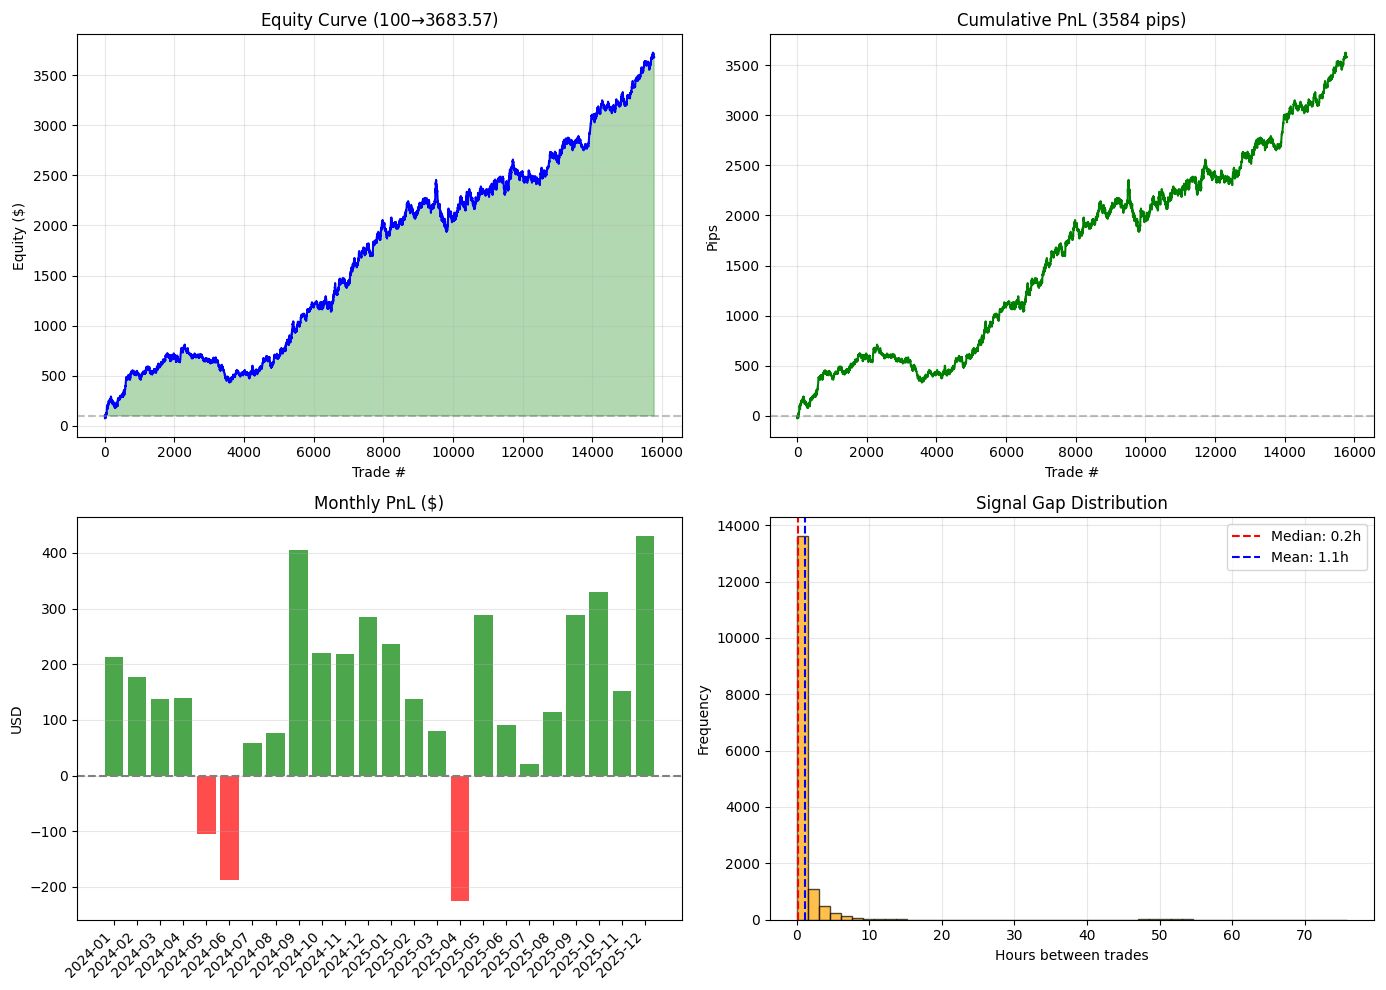


✅ График хадгалагдлаа: models/signal_generator_v23/backtest_2024_2025.png


In [17]:
# =============================================
# 2024-2025 BACKTEST RESULTS & SIGNAL GAP ANALYSIS
# =============================================

print("=" * 60)
print("2024-2025 BACKTEST RESULTS WITH $100 STARTING CAPITAL")
print("=" * 60)

# Basic stats
if len(trades_df_2024) > 0:
    wins = len(trades_df_2024[trades_df_2024['pnl_pips'] > 0])
    losses = len(trades_df_2024[trades_df_2024['pnl_pips'] < 0])
    total_trades = len(trades_df_2024)
    win_rate = wins / total_trades * 100 if total_trades > 0 else 0
    
    gross_profit = trades_df_2024[trades_df_2024['pnl_usd'] > 0]['pnl_usd'].sum()
    gross_loss = abs(trades_df_2024[trades_df_2024['pnl_usd'] < 0]['pnl_usd'].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    total_pips = trades_df_2024['pnl_pips'].sum()
    total_usd = trades_df_2024['pnl_usd'].sum()
    final_equity = STARTING_CAPITAL + total_usd
    
    # Equity tracking
    equity_curve = [STARTING_CAPITAL]
    for pnl in trades_df_2024['pnl_usd'].values:
        equity_curve.append(equity_curve[-1] + pnl)
    
    equity_arr = np.array(equity_curve)
    peak = np.maximum.accumulate(equity_arr)
    drawdown = (peak - equity_arr) / peak * 100
    max_dd = drawdown.max()
    
    # Max equity
    max_equity = equity_arr.max()
    min_equity = equity_arr.min()
    
    print(f"\n📊 АРИЛЖААНЫ СТАТИСТИК:")
    print(f"  Нийт арилжаа: {total_trades}")
    print(f"  Ялсан: {wins} ({win_rate:.1f}%)")
    print(f"  Алдсан: {losses}")
    print(f"  Profit Factor: {profit_factor:.2f}")
    
    print(f"\n💰 АШИГ/АЛДАГДАЛ:")
    print(f"  Нийт pips: {total_pips:.1f}")
    print(f"  Нийт USD: ${total_usd:.2f}")
    print(f"  Эхлэлийн хөрөнгө: ${STARTING_CAPITAL}")
    print(f"  Эцсийн хөрөнгө: ${final_equity:.2f}")
    print(f"  Өсөлт: {((final_equity/STARTING_CAPITAL)-1)*100:.1f}%")
    
    print(f"\n📉 ЭРСДЭЛ:")
    print(f"  Max Drawdown: {max_dd:.1f}%")
    print(f"  Хамгийн их хөрөнгө: ${max_equity:.2f}")
    print(f"  Хамгийн бага хөрөнгө: ${min_equity:.2f}")
    
    # Monthly breakdown
    trades_df_2024['month'] = trades_df_2024['entry_time'].dt.to_period('M')
    monthly = trades_df_2024.groupby('month').agg({
        'pnl_usd': 'sum',
        'pnl_pips': 'sum',
        'entry_time': 'count'
    }).rename(columns={'entry_time': 'trades'})
    
    print(f"\n📅 САРЫН ЗАДАРГАА:")
    profitable_months = 0
    for month, row in monthly.iterrows():
        status = "✅" if row['pnl_usd'] > 0 else "❌"
        print(f"  {month}: {int(row['trades']):3d} trades, {row['pnl_pips']:+7.1f} pips, ${row['pnl_usd']:+7.2f} {status}")
        if row['pnl_usd'] > 0:
            profitable_months += 1
    
    print(f"\n  Ашигтай сарууд: {profitable_months}/{len(monthly)} ({profitable_months/len(monthly)*100:.0f}%)")
else:
    print("Арилжаа байхгүй!")

# =============================================
# SIGNAL GAP ANALYSIS - Longest periods without signals
# =============================================
print("\n" + "=" * 60)
print("СИГНАЛ ЗАВСРЫН ШИНЖИЛГЭЭ")
print("(Арилжааны сигнал байхгүй байгаа хамгийн урт хугацаанууд)")
print("=" * 60)

if len(trades_df_2024) > 0:
    # Sort by entry time
    sorted_trades = trades_df_2024.sort_values('entry_time').reset_index(drop=True)
    
    # Calculate gaps between trades
    signal_gaps = []
    
    # First gap - from data start to first trade
    first_trade_time = sorted_trades['entry_time'].iloc[0]
    data_start = test_data_2024['5min'].index.min()
    first_gap_hours = (first_trade_time - data_start).total_seconds() / 3600
    signal_gaps.append({
        'start': data_start,
        'end': first_trade_time,
        'hours': first_gap_hours,
        'days': first_gap_hours / 24
    })
    
    # Gaps between trades
    for i in range(1, len(sorted_trades)):
        prev_time = sorted_trades['entry_time'].iloc[i-1]
        curr_time = sorted_trades['entry_time'].iloc[i]
        gap_hours = (curr_time - prev_time).total_seconds() / 3600
        signal_gaps.append({
            'start': prev_time,
            'end': curr_time,
            'hours': gap_hours,
            'days': gap_hours / 24
        })
    
    # Last gap - from last trade to data end
    last_trade_time = sorted_trades['entry_time'].iloc[-1]
    data_end = test_data_2024['5min'].index.max()
    last_gap_hours = (data_end - last_trade_time).total_seconds() / 3600
    signal_gaps.append({
        'start': last_trade_time,
        'end': data_end,
        'hours': last_gap_hours,
        'days': last_gap_hours / 24
    })
    
    # Sort by gap duration
    gaps_df = pd.DataFrame(signal_gaps)
    gaps_df = gaps_df.sort_values('hours', ascending=False).reset_index(drop=True)
    
    print(f"\n🕐 ТОП 10 ХАМГИЙН УРТ СИГНАЛ ЗАВСРУУД:")
    print("-" * 60)
    for i, row in gaps_df.head(10).iterrows():
        print(f"  {i+1}. {row['days']:.1f} өдөр ({row['hours']:.1f} цаг)")
        print(f"     Эхлэл: {row['start']}")
        print(f"     Төгсгөл: {row['end']}")
        print()
    
    # Gap statistics
    print(f"📊 ЗАВСРЫН СТАТИСТИК:")
    print(f"  Нийт завсрын тоо: {len(gaps_df)}")
    print(f"  Дундаж завсар: {gaps_df['hours'].mean():.1f} цаг ({gaps_df['days'].mean():.1f} өдөр)")
    print(f"  Медиан завсар: {gaps_df['hours'].median():.1f} цаг")
    print(f"  Хамгийн урт: {gaps_df['hours'].max():.1f} цаг ({gaps_df['days'].max():.1f} өдөр)")
    print(f"  Хамгийн богино: {gaps_df['hours'].min():.1f} цаг")
    
    # Gaps > 1 day, > 3 days, > 7 days
    gaps_1d = len(gaps_df[gaps_df['days'] > 1])
    gaps_3d = len(gaps_df[gaps_df['days'] > 3])
    gaps_7d = len(gaps_df[gaps_df['days'] > 7])
    print(f"\n  1 өдрөөс их завсар: {gaps_1d} удаа")
    print(f"  3 өдрөөс их завсар: {gaps_3d} удаа")
    print(f"  7 өдрөөс их завсар: {gaps_7d} удаа")

# Plot
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Equity Curve
ax1 = axes[0, 0]
ax1.plot(equity_curve, 'b-', linewidth=1.5)
ax1.axhline(y=STARTING_CAPITAL, color='gray', linestyle='--', alpha=0.5)
ax1.fill_between(range(len(equity_curve)), STARTING_CAPITAL, equity_curve, 
                 where=[e >= STARTING_CAPITAL for e in equity_curve], alpha=0.3, color='green')
ax1.fill_between(range(len(equity_curve)), STARTING_CAPITAL, equity_curve, 
                 where=[e < STARTING_CAPITAL for e in equity_curve], alpha=0.3, color='red')
ax1.set_title(f'Equity Curve ($100 → ${final_equity:.2f})', fontsize=12)
ax1.set_xlabel('Trade #')
ax1.set_ylabel('Equity ($)')
ax1.grid(True, alpha=0.3)

# 2. Cumulative PnL (Pips)
ax2 = axes[0, 1]
cum_pips = trades_df_2024['pnl_pips'].cumsum()
ax2.plot(cum_pips.values, 'g-', linewidth=1.5)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_title(f'Cumulative PnL ({total_pips:.0f} pips)', fontsize=12)
ax2.set_xlabel('Trade #')
ax2.set_ylabel('Pips')
ax2.grid(True, alpha=0.3)

# 3. Monthly PnL
ax3 = axes[1, 0]
months = [str(m) for m in monthly.index]
pnls = monthly['pnl_usd'].values
colors = ['green' if p > 0 else 'red' for p in pnls]
ax3.bar(range(len(months)), pnls, color=colors, alpha=0.7)
ax3.axhline(y=0, color='gray', linestyle='--')
ax3.set_xticks(range(len(months)))
ax3.set_xticklabels(months, rotation=45, ha='right')
ax3.set_title('Monthly PnL ($)', fontsize=12)
ax3.set_ylabel('USD')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Signal Gap Distribution
ax4 = axes[1, 1]
gap_hours_arr = gaps_df['hours'].values
ax4.hist(gap_hours_arr, bins=50, color='orange', alpha=0.7, edgecolor='black')
ax4.axvline(x=gaps_df['hours'].median(), color='red', linestyle='--', label=f'Median: {gaps_df["hours"].median():.1f}h')
ax4.axvline(x=gaps_df['hours'].mean(), color='blue', linestyle='--', label=f'Mean: {gaps_df["hours"].mean():.1f}h')
ax4.set_title('Signal Gap Distribution', fontsize=12)
ax4.set_xlabel('Hours between trades')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/signal_generator_v23/backtest_2024_2025.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ График хадгалагдлаа: models/signal_generator_v23/backtest_2024_2025.png")